## Plots

Fixed parameters for all studies 
- n_episodes: 500000
- gamma: 1
- tau: 0.005
- lr: 0.00005
- epsilon: 1 → 0.01, staying above 0.01 for 60% of training.
- activation: relu
- batch size: 512
- replay memory: 50000

Fixed only if it not otherwise specified
- hidden network sizes: (128, 128)
- loss: MAE
- agent: DQN

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

smooth_factor_reward = 50
smooth_factor_loss = 20

def compute_mean_std(df_list):
    
    combined = pd.concat(df_list, keys=range(len(df_list))).reset_index(level=0)
    
    grouped = combined.groupby('episode').agg(
        avg_reward_mean=('avg_reward', 'mean'),
        avg_reward_std=('avg_reward', 'std'),
        loss_mean=('loss', 'mean'),
        loss_std=('loss', 'std')
    )
    
    episodes = grouped.index.to_numpy()
    avg_reward_mean = grouped['avg_reward_mean'].to_numpy()
    avg_reward_std = grouped['avg_reward_std'].to_numpy()
    loss_mean = grouped['loss_mean'].to_numpy()
    loss_std = grouped['loss_std'].to_numpy()
    
    # Smoothing using a moving average with edge handling
    def smooth_data(data, smooth_factor):
        if smooth_factor < 2:
            return data # No smoothing
        window = max(1, smooth_factor)
        # Pad the data at both ends with reflection
        padded_data = np.pad(data, pad_width=(window // 2,), mode='reflect')
        smoothed = np.convolve(padded_data, np.ones(window) / window, mode='valid')
        return smoothed
    
    avg_reward_mean = smooth_data(avg_reward_mean, smooth_factor_reward)
    avg_reward_std = smooth_data(avg_reward_std, smooth_factor_reward)
    loss_mean = smooth_data(loss_mean, smooth_factor_loss)
    loss_std = smooth_data(loss_std, smooth_factor_loss)
    
    # Only take 500 data points
    indices = np.linspace(0, len(episodes) - 1, 500, dtype=int)
    episodes = episodes[indices]
    avg_reward_mean = avg_reward_mean[indices]
    avg_reward_std = avg_reward_std[indices]
    loss_mean = loss_mean[indices]
    loss_std = loss_std[indices]
    return episodes, avg_reward_mean, avg_reward_std, loss_mean, loss_std

def large_number_formatter(x, pos):
    if x >= 1e3:
        return f'{x * 1e-3:.0f}k'
    return f'{x:.0f}'

def apply_formatter():
    for ax in plt.gcf().axes:
        ax.xaxis.set_major_formatter(FuncFormatter(large_number_formatter))

In [2]:
plt.rcParams['font.family'] = 'serif' # or 'sans-serif' or 'monospace'
plt.rcParams['font.serif'] = 'cmr10'
plt.rcParams['font.sans-serif'] = 'cmss10'
plt.rcParams['font.monospace'] = 'cmtt10'
plt.rcParams["axes.formatter.use_mathtext"] = True # to fix the minus signs
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (10, 8)
os.makedirs('figures', exist_ok=True)

alpha = 0.15
lw = 0.8
colors = ["green", "darkorchid", "firebrick", "royalblue"]

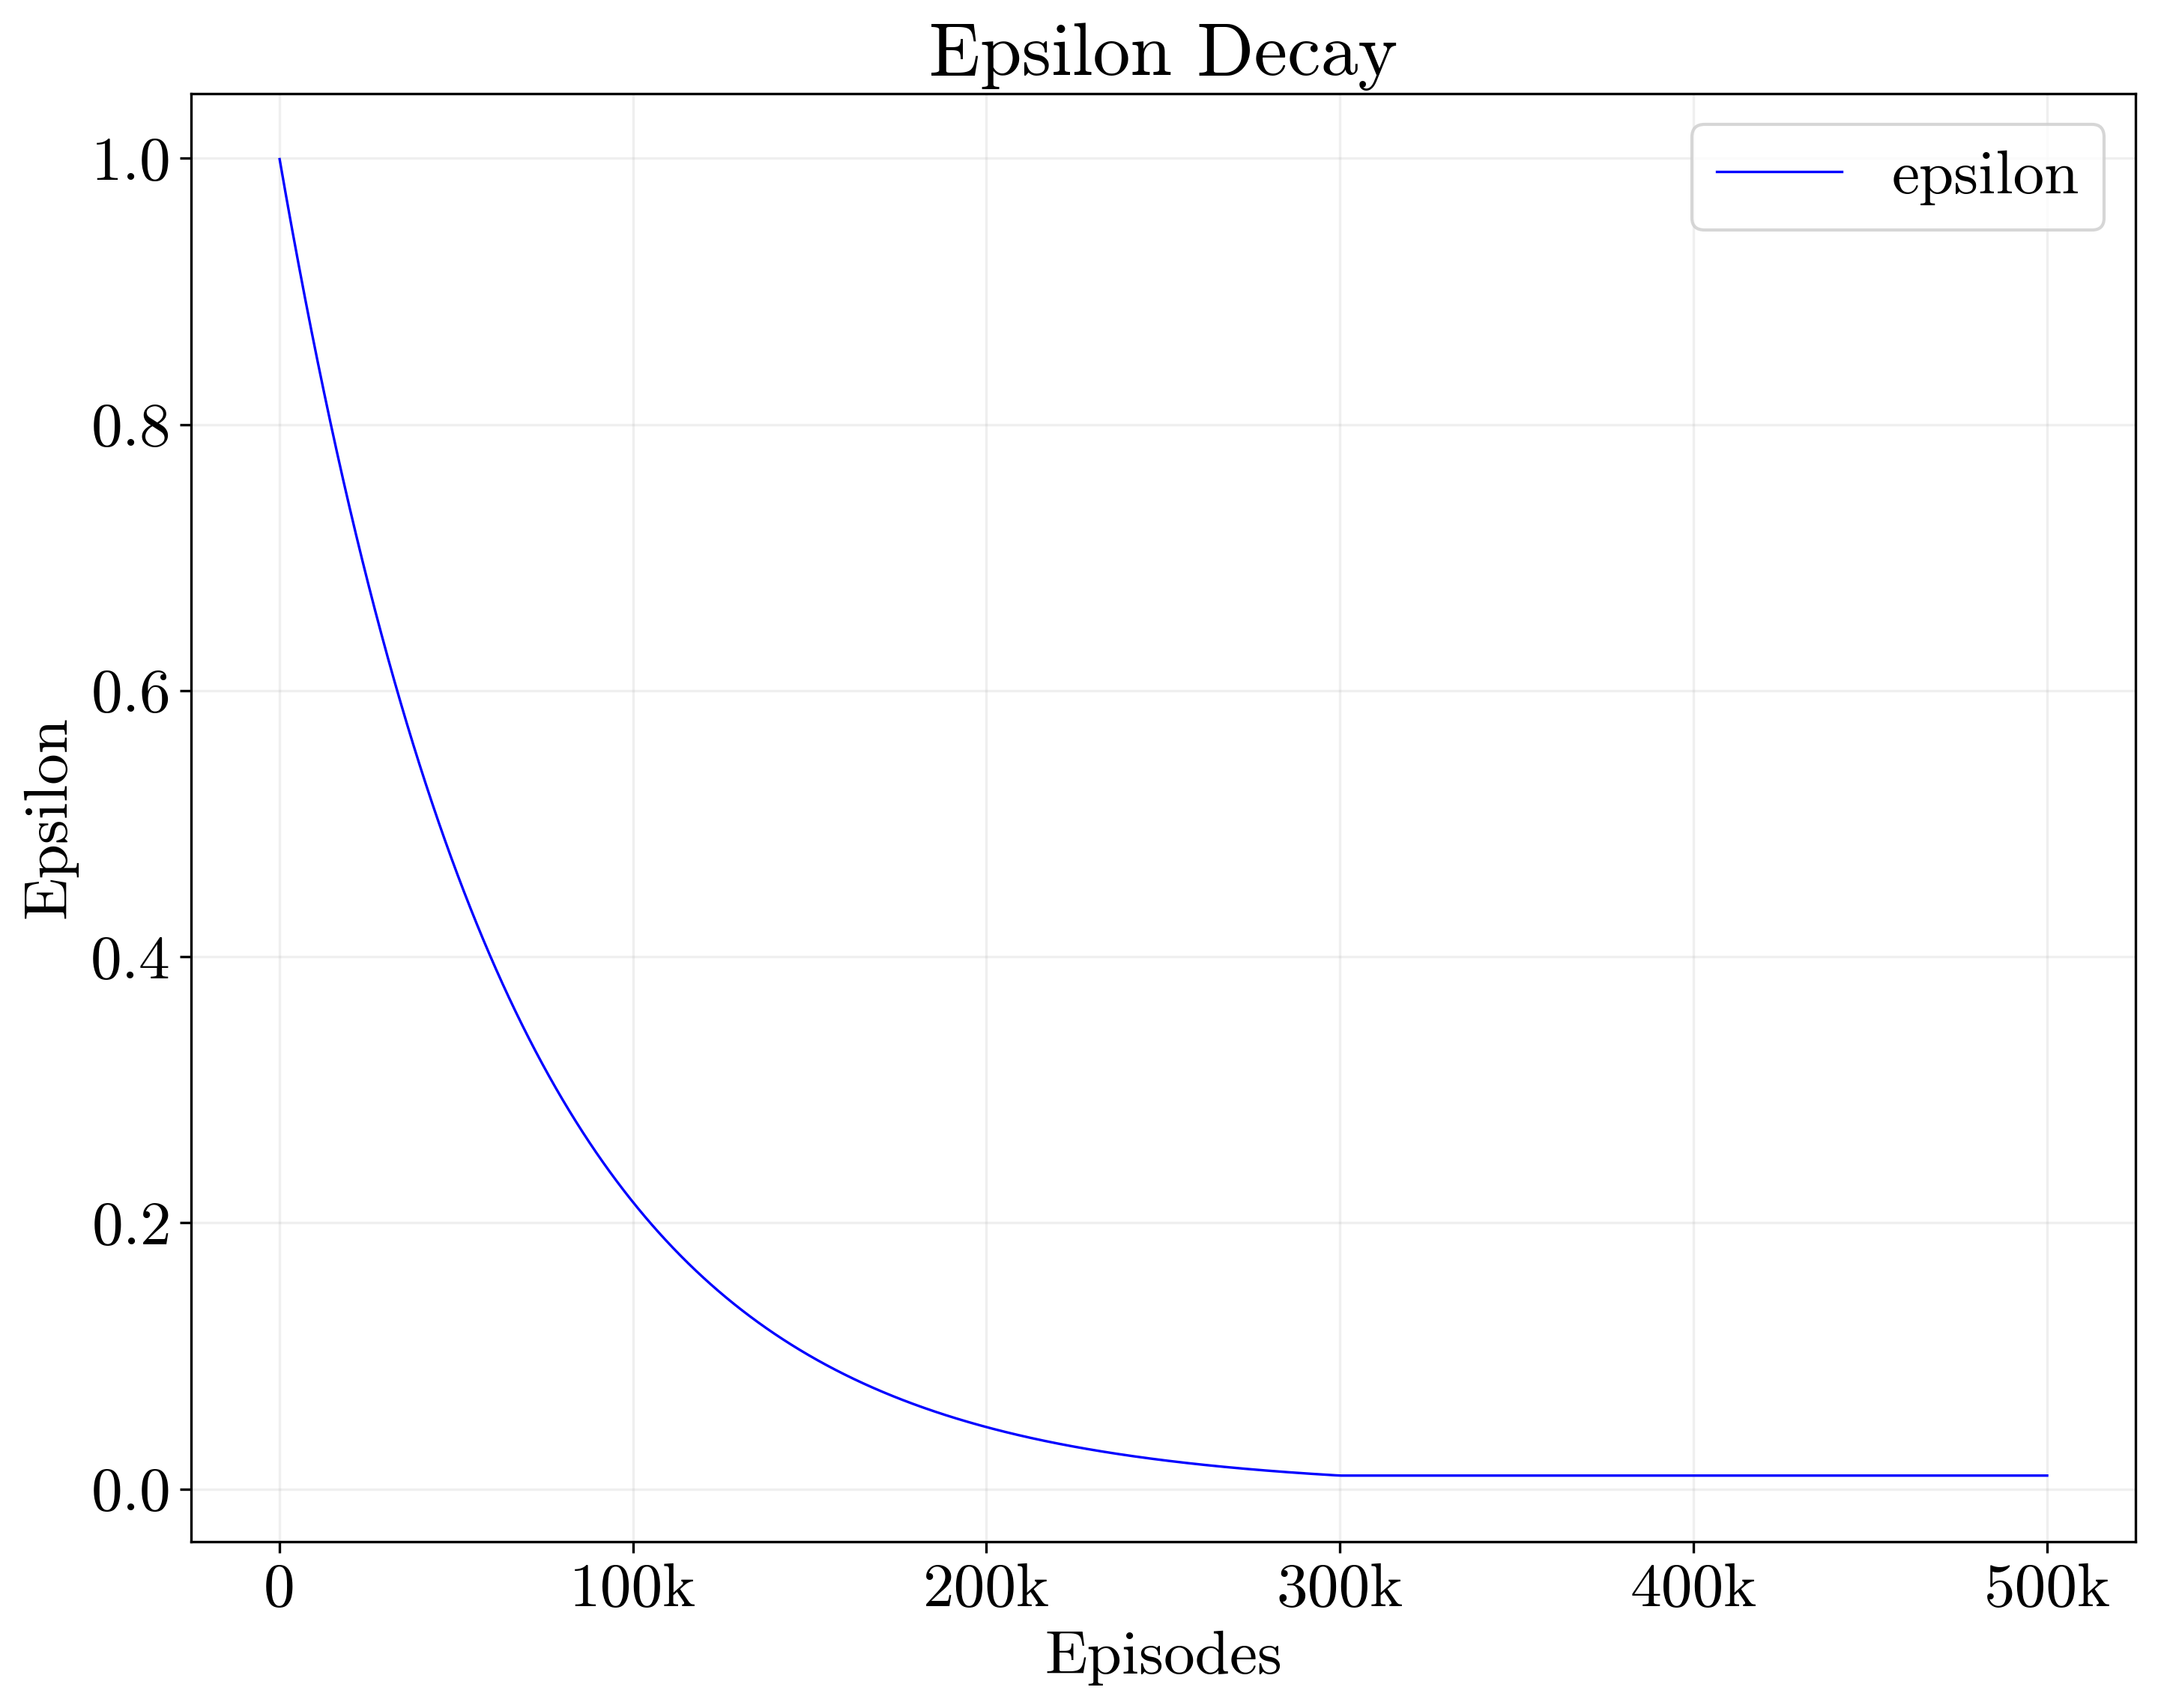

In [3]:
csv_path = "./csv_logs/network_size_comparison"

df = pd.read_csv(os.path.join(csv_path, "log_dqn_128-128_0.csv"))
episodes, eps_data = df["episode"], df["epsilon"]

plt.figure()
plt.plot(episodes, eps_data, label="epsilon", color="blue", lw=lw)
plt.xlabel("Episodes")
plt.ylabel("Epsilon")
plt.title('Epsilon Decay')
plt.legend()
plt.grid(alpha=0.2)
apply_formatter()
plt.tight_layout()
plt.savefig('figures/epsilon_decay.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### Comparing hidden network sizes (128, 128) vs. (256, 256) vs. (512, 512)

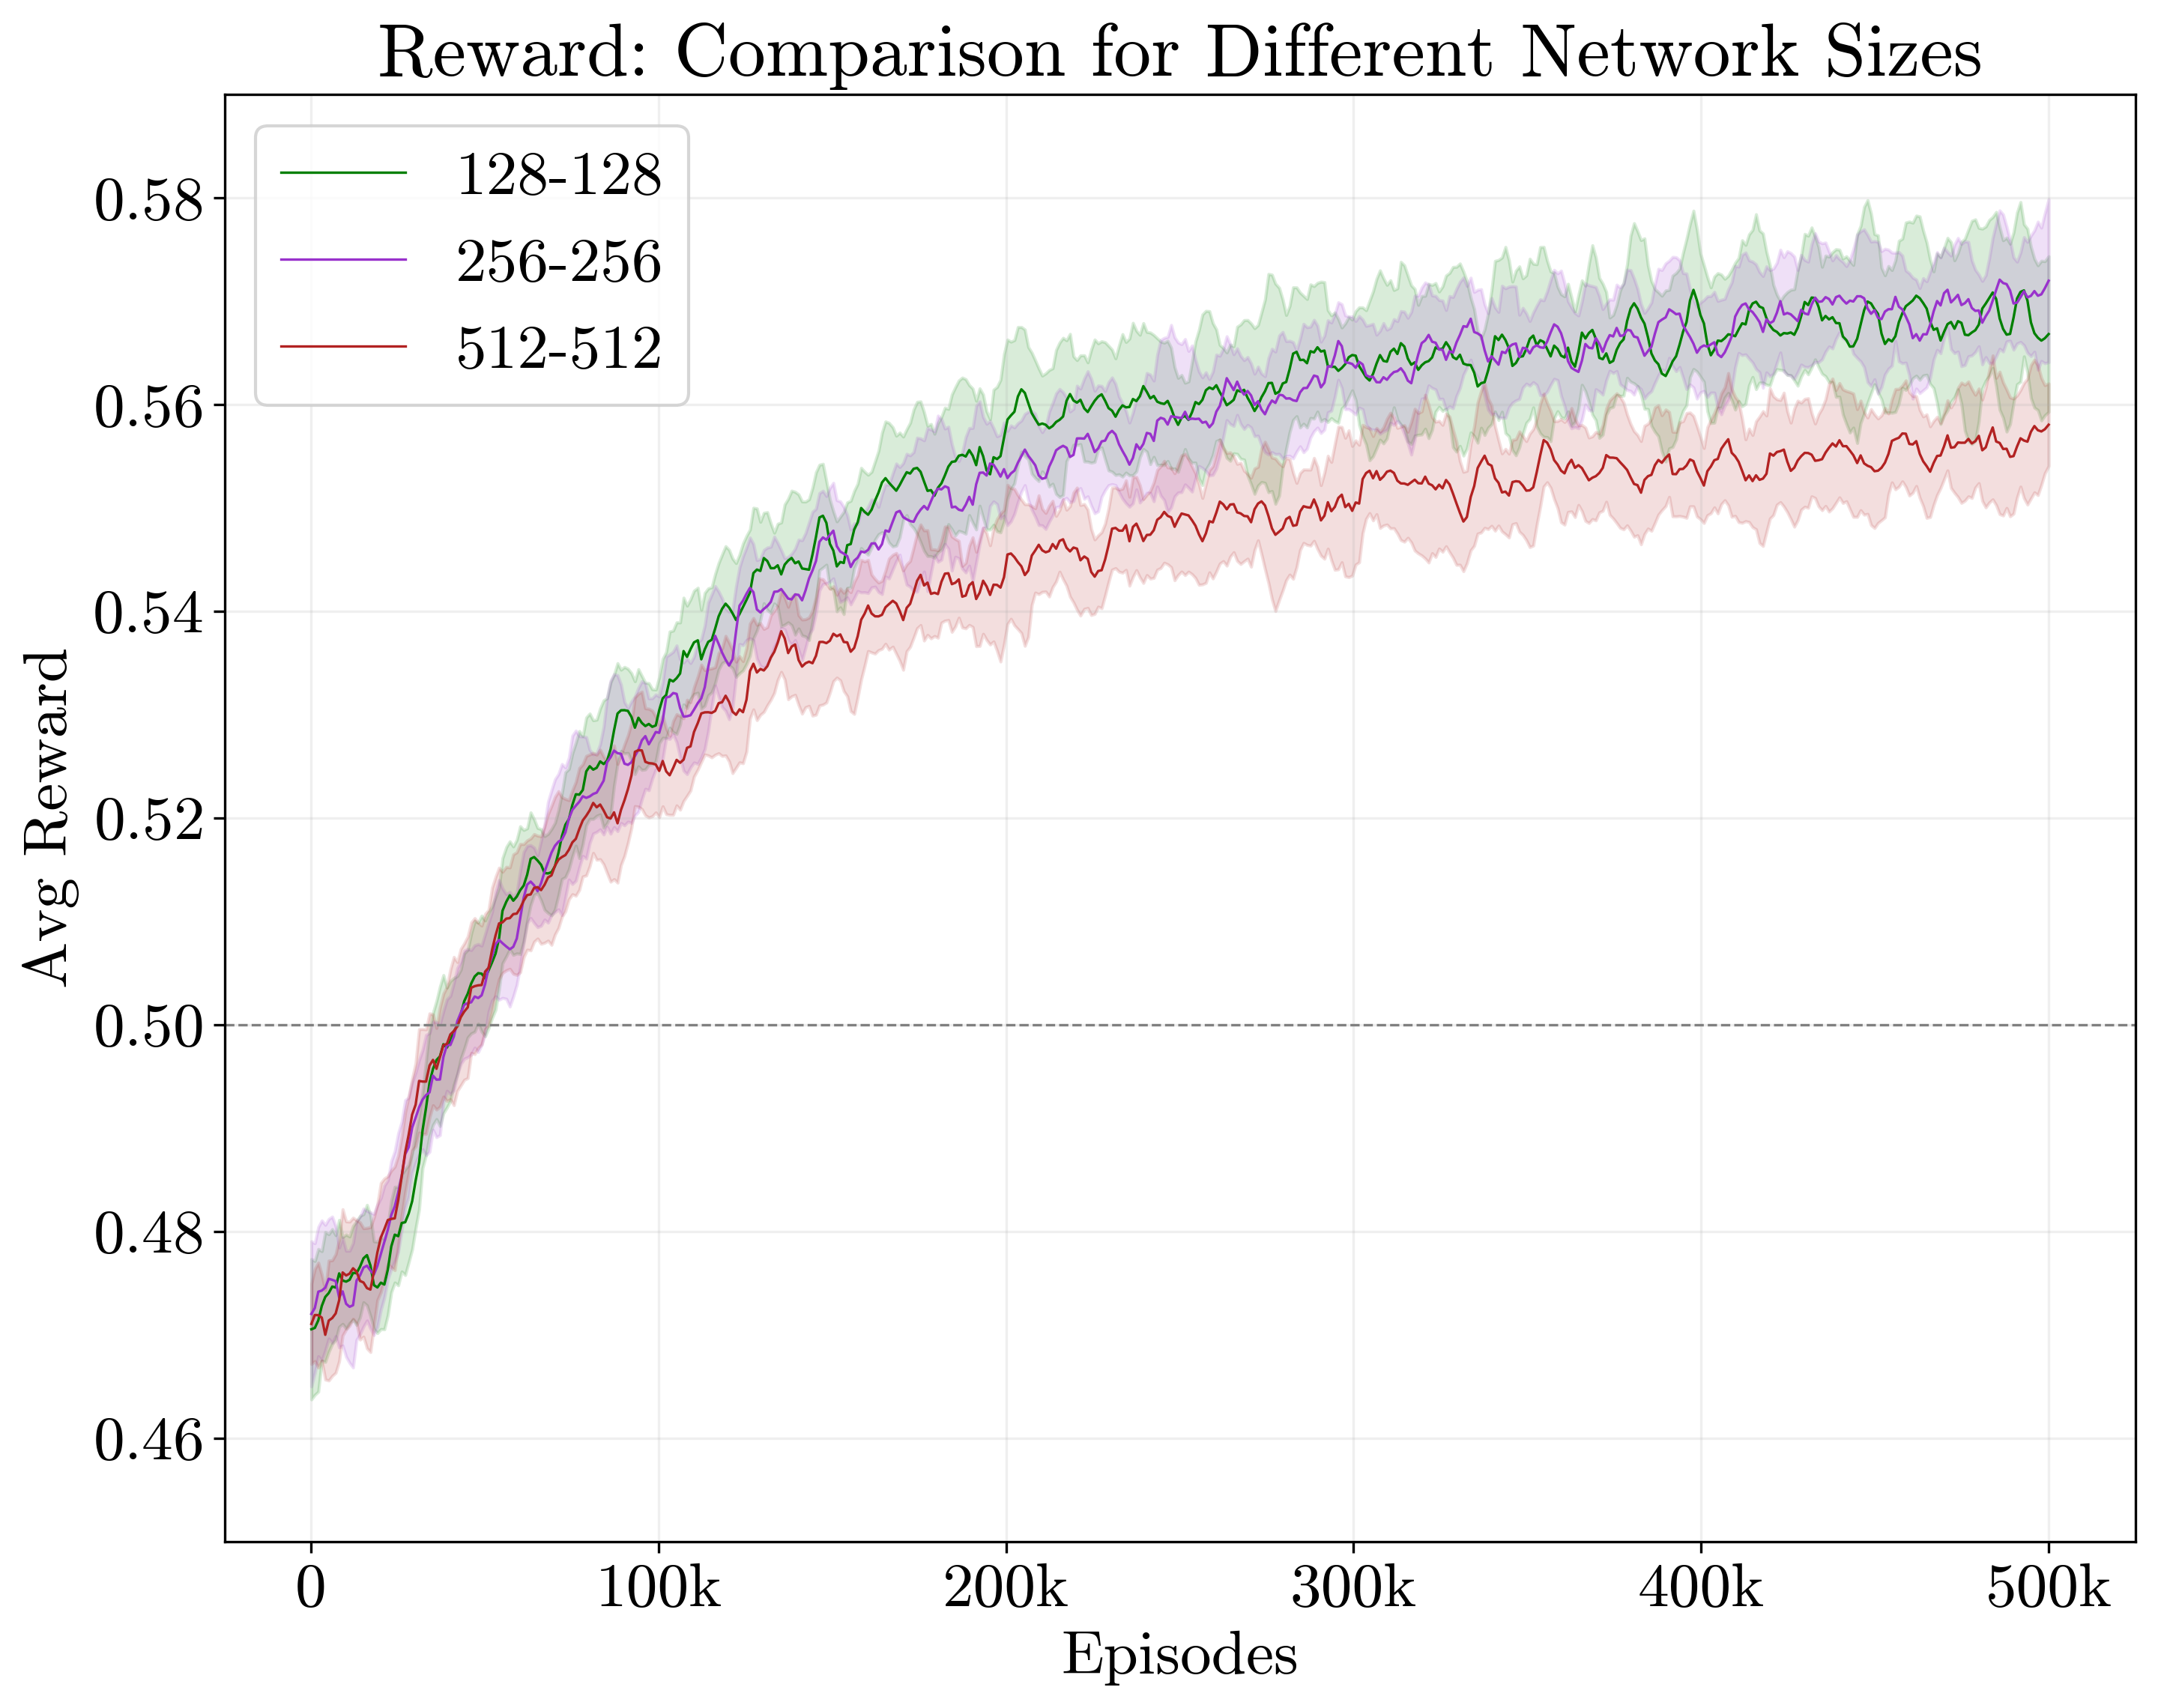

In [4]:
csv_path = "./csv_logs/network_size_comparison"

csv_128 = [os.path.join(csv_path, "log_dqn_128-128_0.csv"), os.path.join(csv_path, "log_dqn_128-128_1.csv"), os.path.join(csv_path, "log_dqn_128-128_2.csv")]
csv_256 = [os.path.join(csv_path, "log_dqn_256-256_0.csv"), os.path.join(csv_path, "log_dqn_256-256_1.csv"), os.path.join(csv_path, "log_dqn_256-256_2.csv")]
csv_512 = [os.path.join(csv_path, "log_dqn_512-512_0.csv"), os.path.join(csv_path, "log_dqn_512-512_1.csv"), os.path.join(csv_path, "log_dqn_512-512_2.csv")]

data_128 = [pd.read_csv(f) for f in csv_128]
data_256 = [pd.read_csv(f) for f in csv_256]
data_512 = [pd.read_csv(f) for f in csv_512]

episodes_128, avg_reward_mean_128, avg_reward_std_128, loss_mean_128, loss_std_128 = compute_mean_std(data_128)
episodes_256, avg_reward_mean_256, avg_reward_std_256, loss_mean_256, loss_std_256 = compute_mean_std(data_256)
episodes_512, avg_reward_mean_512, avg_reward_std_512, loss_mean_512, loss_std_512 = compute_mean_std(data_512)

plt.figure()

plt.plot(episodes_128, avg_reward_mean_128, label='128-128', color=colors[0], linewidth=lw)
plt.fill_between(episodes_128, avg_reward_mean_128 - avg_reward_std_128, avg_reward_mean_128 + avg_reward_std_128, color=colors[0], alpha=alpha)

plt.plot(episodes_256, avg_reward_mean_256, label='256-256', color=colors[1], linewidth=lw)
plt.fill_between(episodes_256, avg_reward_mean_256 - avg_reward_std_256, avg_reward_mean_256 + avg_reward_std_256, color=colors[1], alpha=alpha)

plt.plot(episodes_512, avg_reward_mean_512, label='512-512', color=colors[2], linewidth=lw)
plt.fill_between(episodes_512, avg_reward_mean_512 - avg_reward_std_512, avg_reward_mean_512 + avg_reward_std_512, color=colors[2], alpha=alpha)

plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=lw)

plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.ylim(0.45, 0.59)
plt.title('Reward: Comparison for Different Network Sizes')
plt.legend()
plt.grid(alpha=0.2)
apply_formatter()
plt.tight_layout()
plt.savefig('figures/network_size_reward.pdf', dpi=300, bbox_inches='tight')
plt.show()

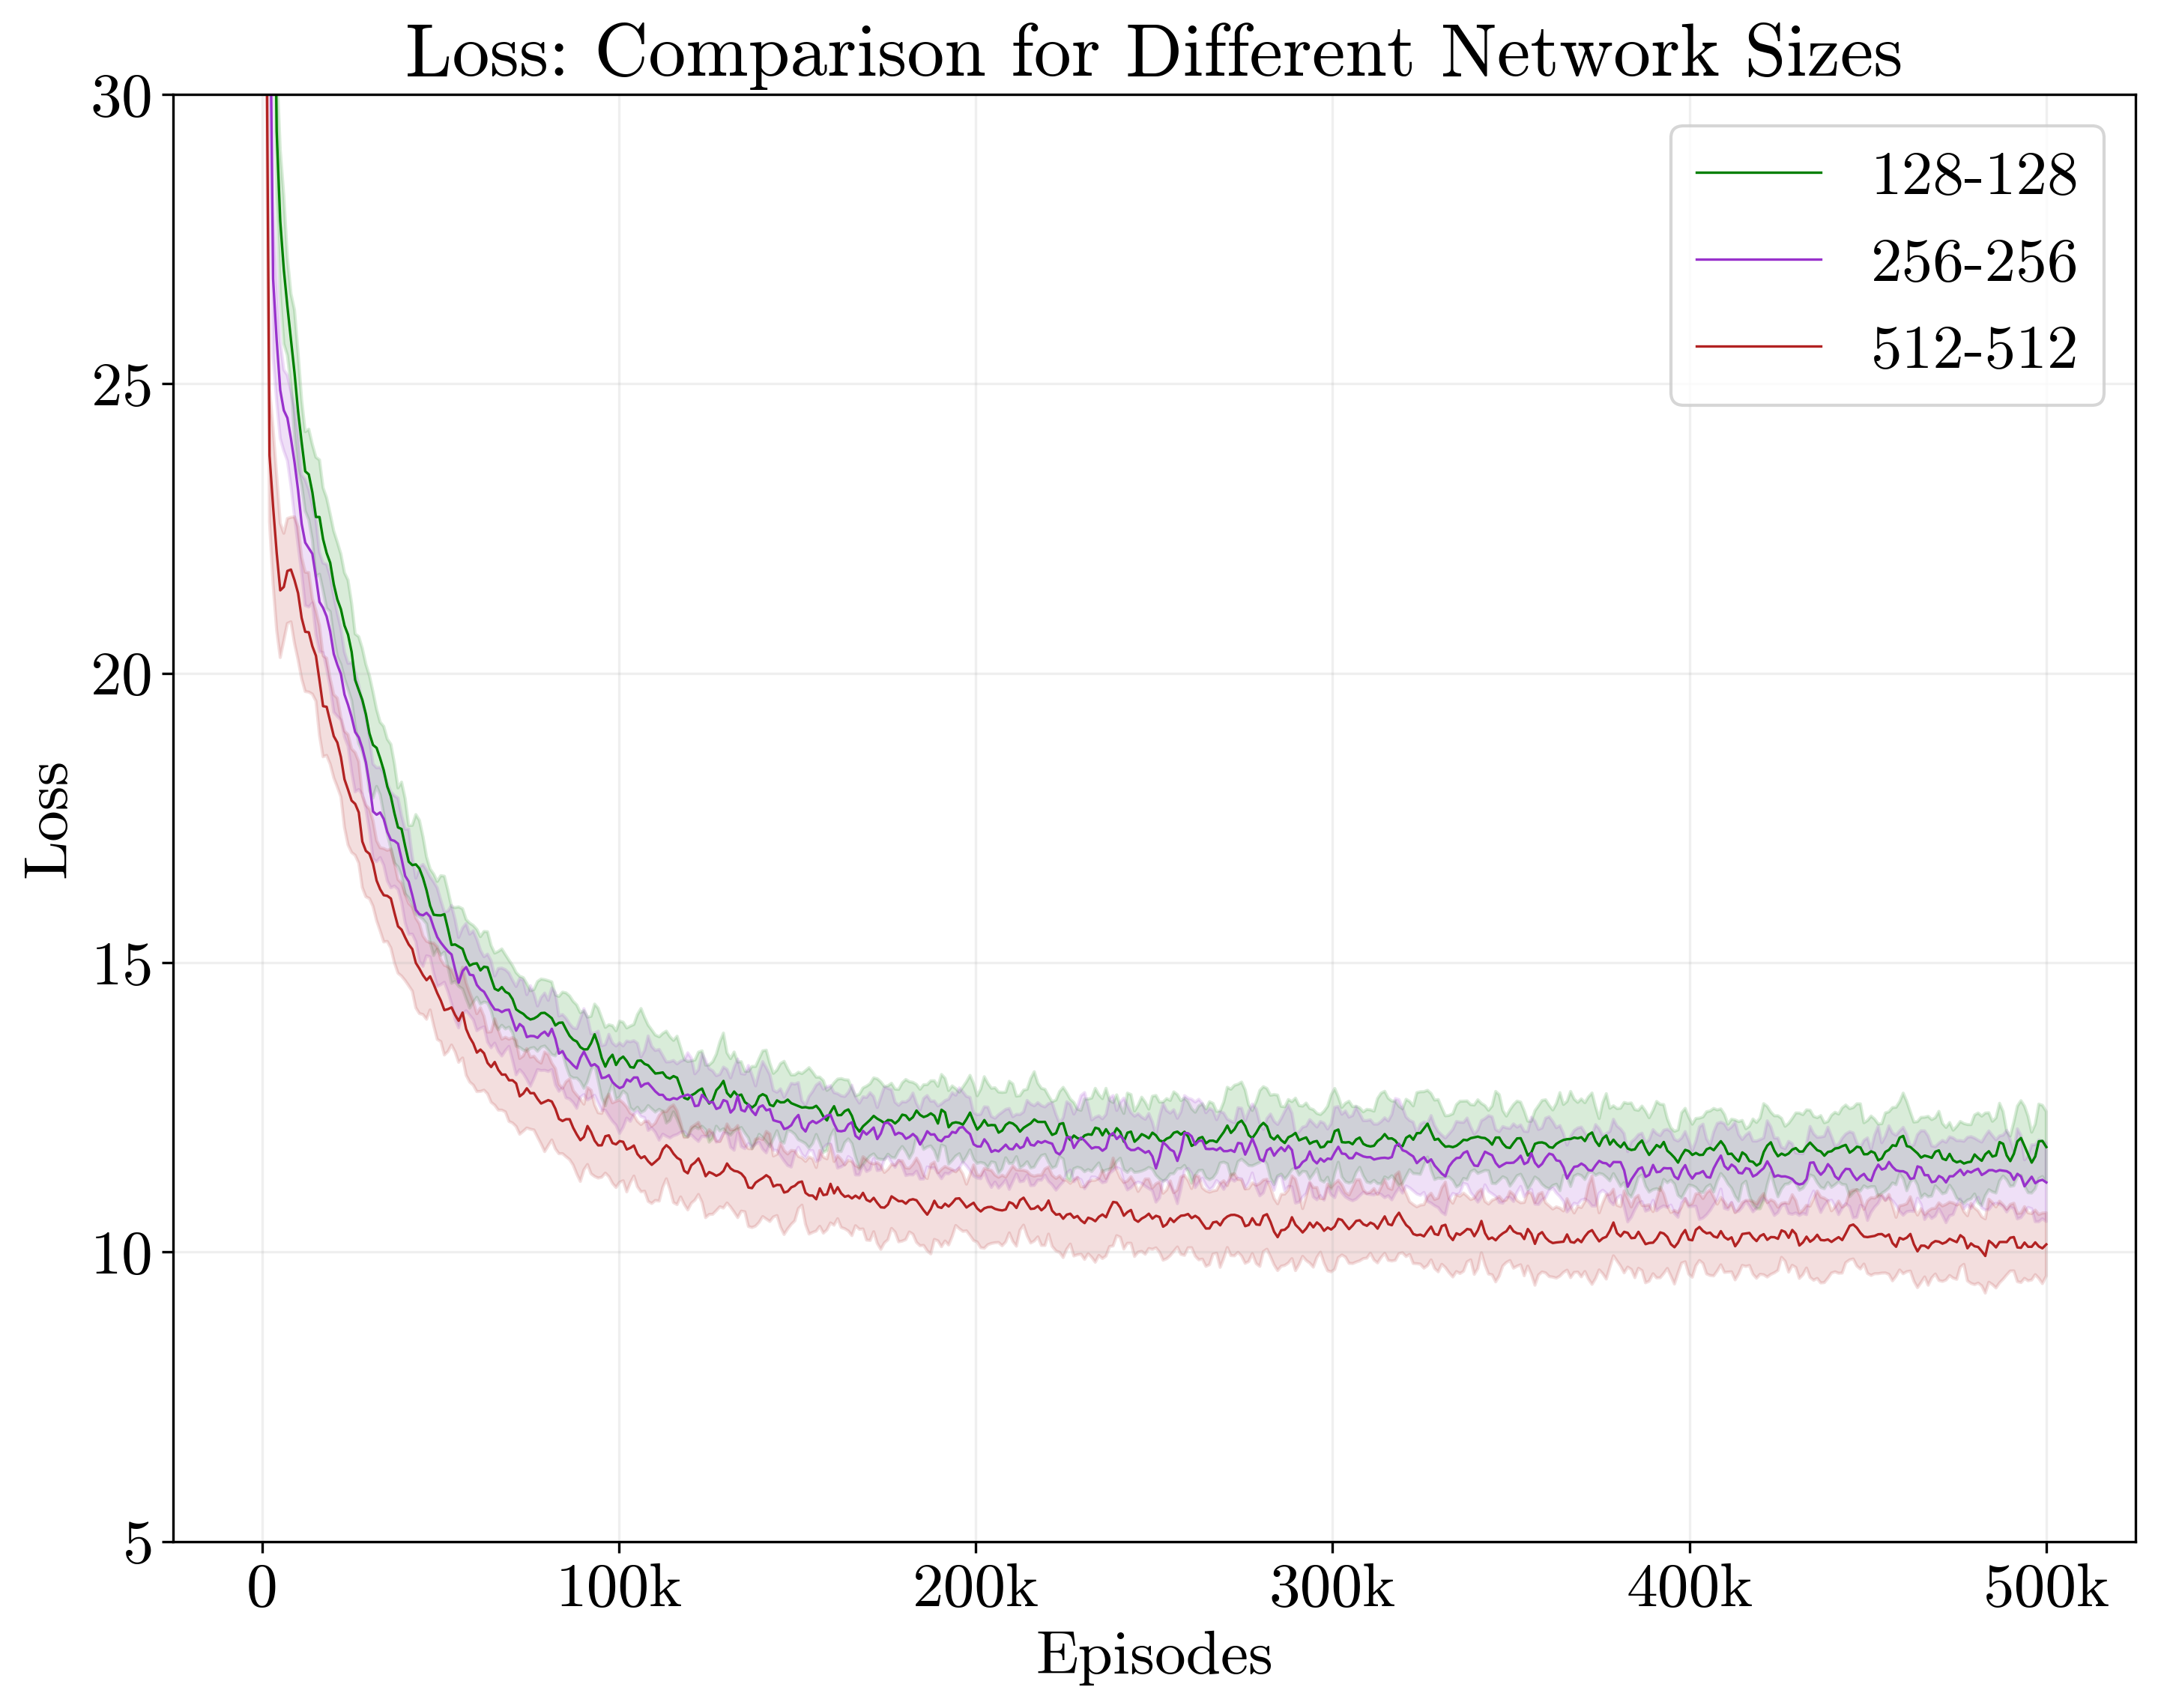

In [5]:
plt.figure()

plt.plot(episodes_128, loss_mean_128, label='128-128', color=colors[0], linewidth=lw)
plt.fill_between(episodes_128, loss_mean_128 - loss_std_128, loss_mean_128 + loss_std_128, color=colors[0], alpha=alpha)

plt.plot(episodes_256, loss_mean_256, label='256-256', color=colors[1], linewidth=lw)
plt.fill_between(episodes_256, loss_mean_256 - loss_std_256, loss_mean_256 + loss_std_256, color=colors[1], alpha=alpha)

plt.plot(episodes_512, loss_mean_512, label='512-512', color=colors[2], linewidth=lw)
plt.fill_between(episodes_512, loss_mean_512 - loss_std_512, loss_mean_512 + loss_std_512, color=colors[2], alpha=alpha)

plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.ylim(5, 30)
plt.title('Loss: Comparison for Different Network Sizes')
plt.legend()
plt.grid(alpha=0.2)
apply_formatter()
plt.tight_layout()
plt.savefig('figures/network_size_loss.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### Comparing loss: MSE vs. MAE

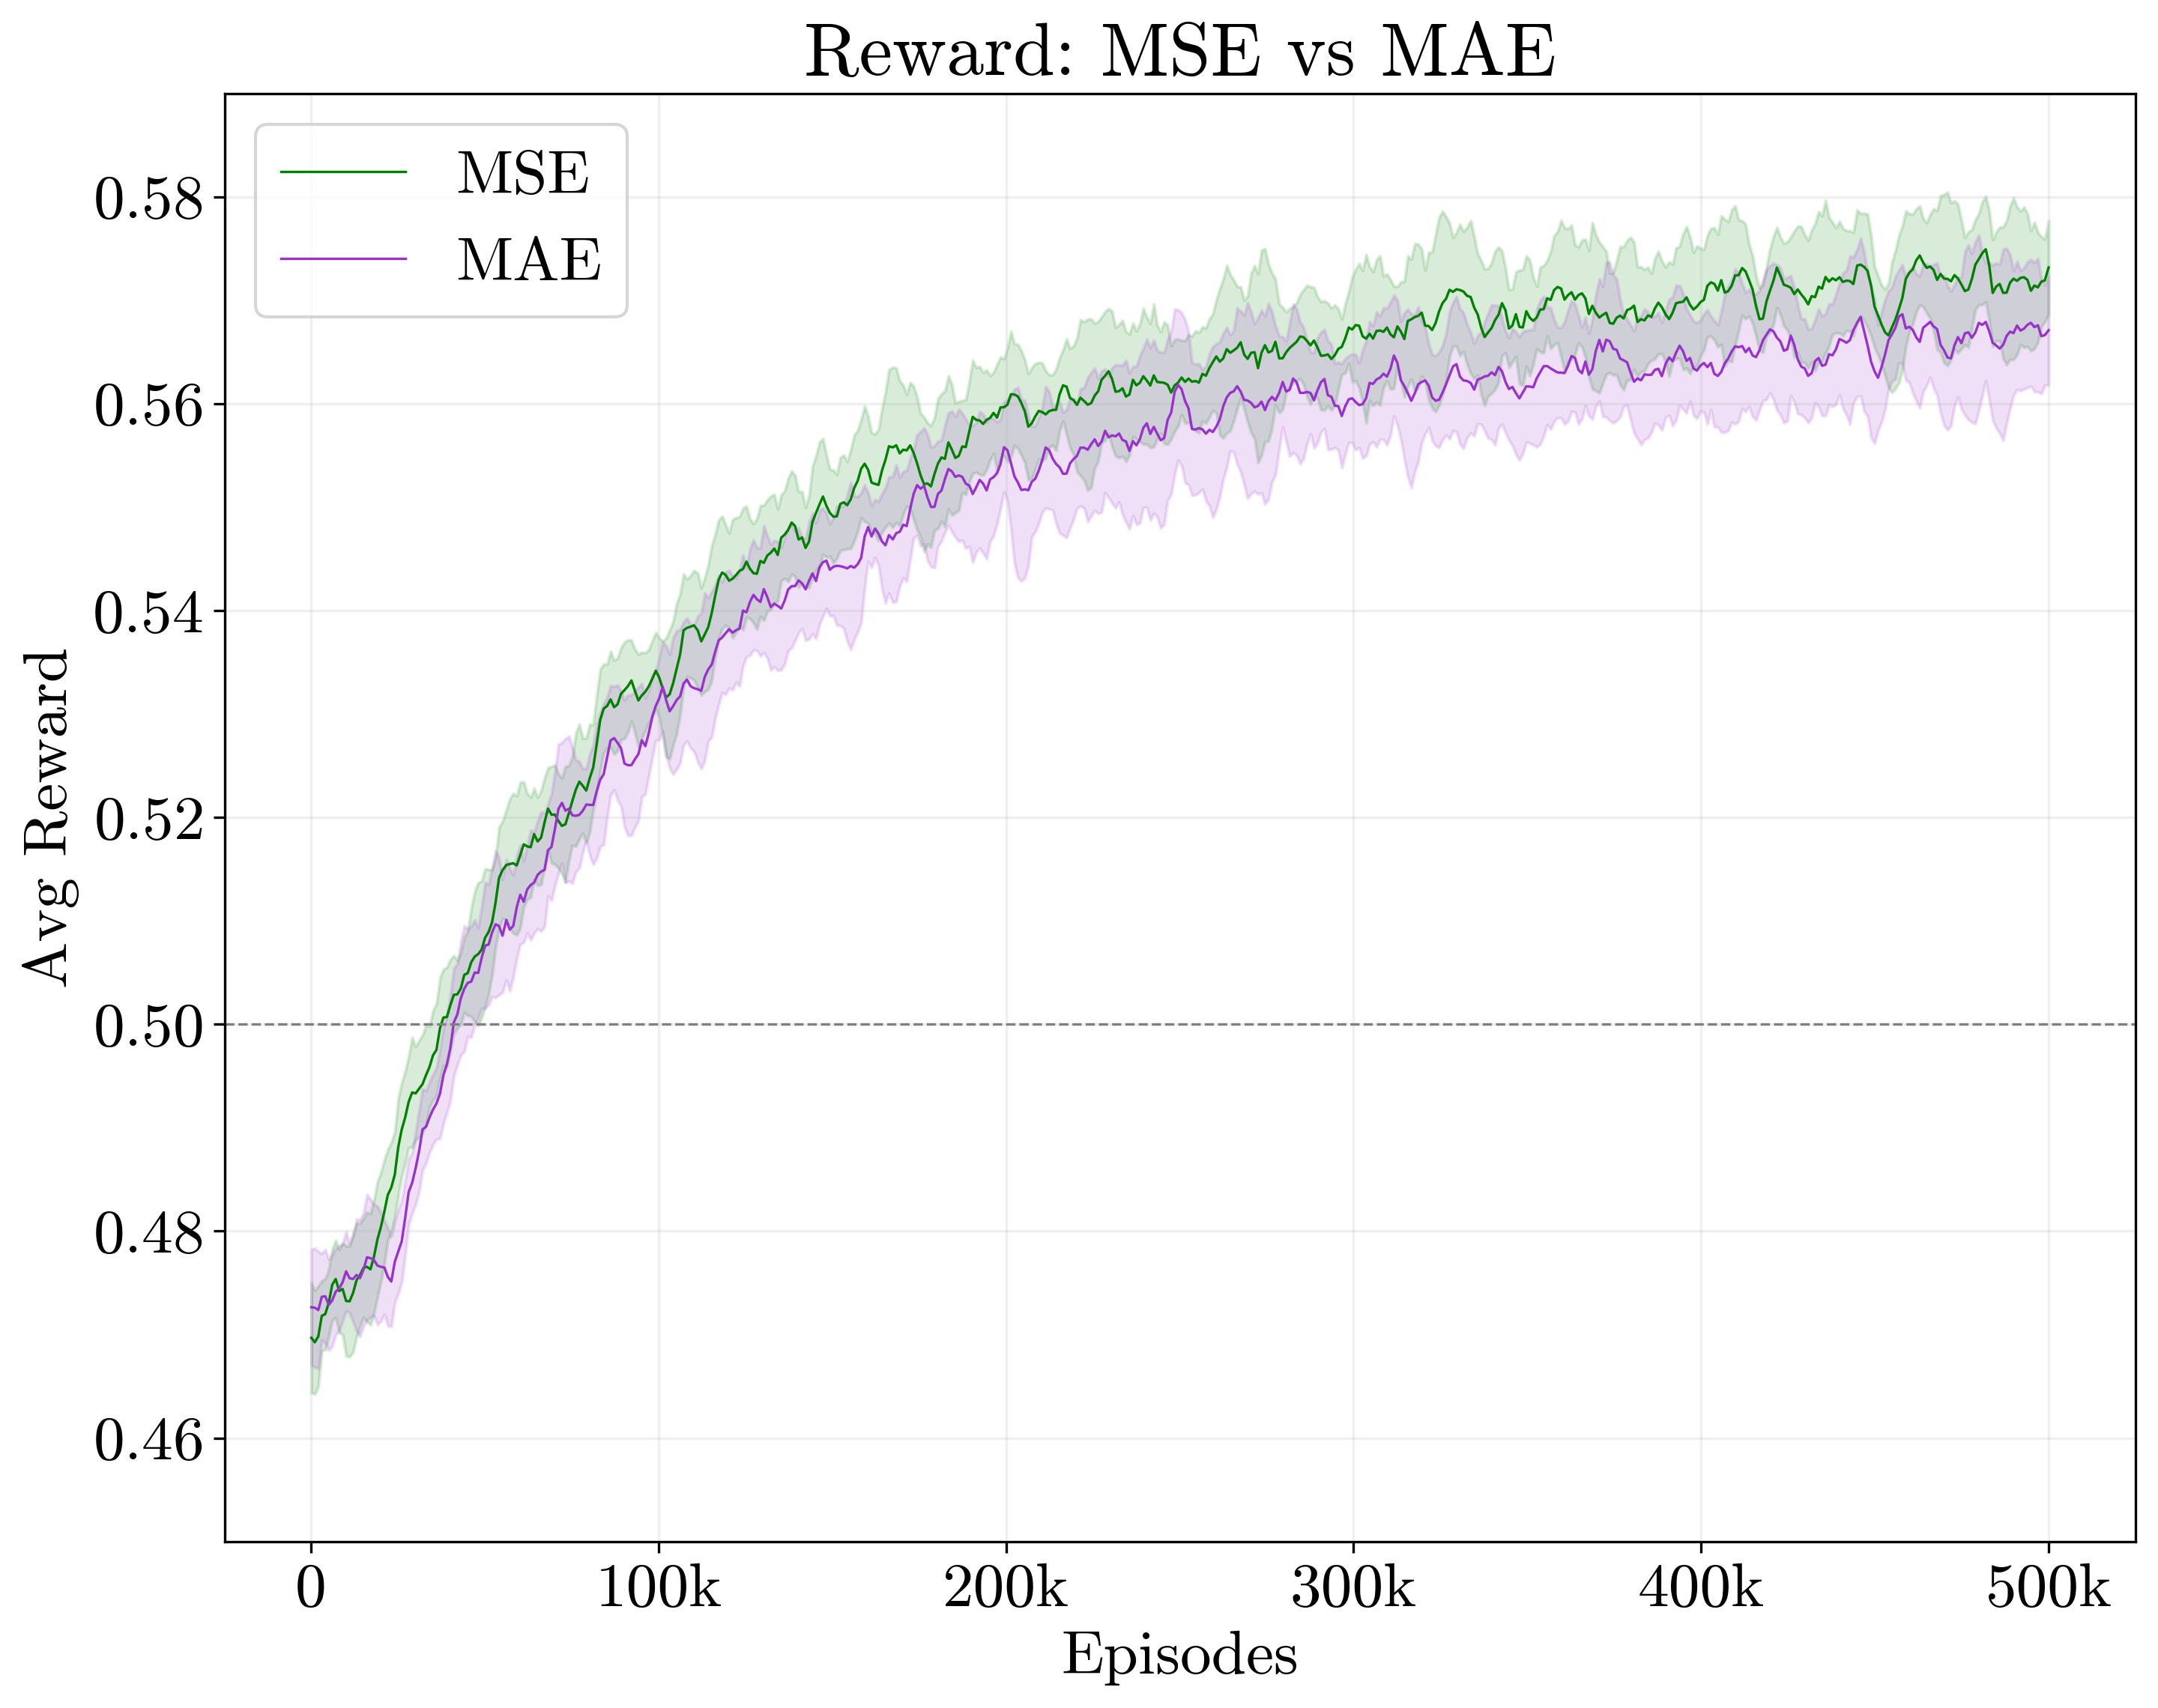

In [6]:
csv_path = "./csv_logs/loss_comparison"

csv_mse = [os.path.join(csv_path, "log_dqn_mse_0.csv"), os.path.join(csv_path, "log_dqn_mse_1.csv"), os.path.join(csv_path, "log_dqn_mse_2.csv")]
csv_mae = [os.path.join(csv_path, "log_dqn_smooth_l1_0.csv"), os.path.join(csv_path, "log_dqn_smooth_l1_1.csv"), os.path.join(csv_path, "log_dqn_smooth_l1_2.csv")]

data_mse = [pd.read_csv(f) for f in csv_mse]
data_mae = [pd.read_csv(f) for f in csv_mae]

episodes_mse, avg_reward_mean_mse, avg_reward_std_mse, loss_mean_mse, loss_std_mse = compute_mean_std(data_mse)
episodes_mae, avg_reward_mean_mae, avg_reward_std_mae, loss_mean_mae, loss_std_mae = compute_mean_std(data_mae)

plt.figure()

plt.plot(episodes_mse, avg_reward_mean_mse, label='MSE', color=colors[0], linewidth=lw)
plt.fill_between(episodes_mse, avg_reward_mean_mse - avg_reward_std_mse, avg_reward_mean_mse + avg_reward_std_mse, color=colors[0], alpha=alpha)

plt.plot(episodes_mae, avg_reward_mean_mae, label='MAE', color=colors[1], linewidth=lw)
plt.fill_between(episodes_mae, avg_reward_mean_mae - avg_reward_std_mae, avg_reward_mean_mae + avg_reward_std_mae, color=colors[1], alpha=alpha)

plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=lw)

plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.ylim(0.45, 0.59)
plt.title('Reward: MSE vs MAE')
plt.legend()
plt.grid(alpha=0.2)
apply_formatter()
plt.tight_layout()
plt.savefig('figures/loss_reward.pdf', dpi=300, bbox_inches='tight')
plt.show()

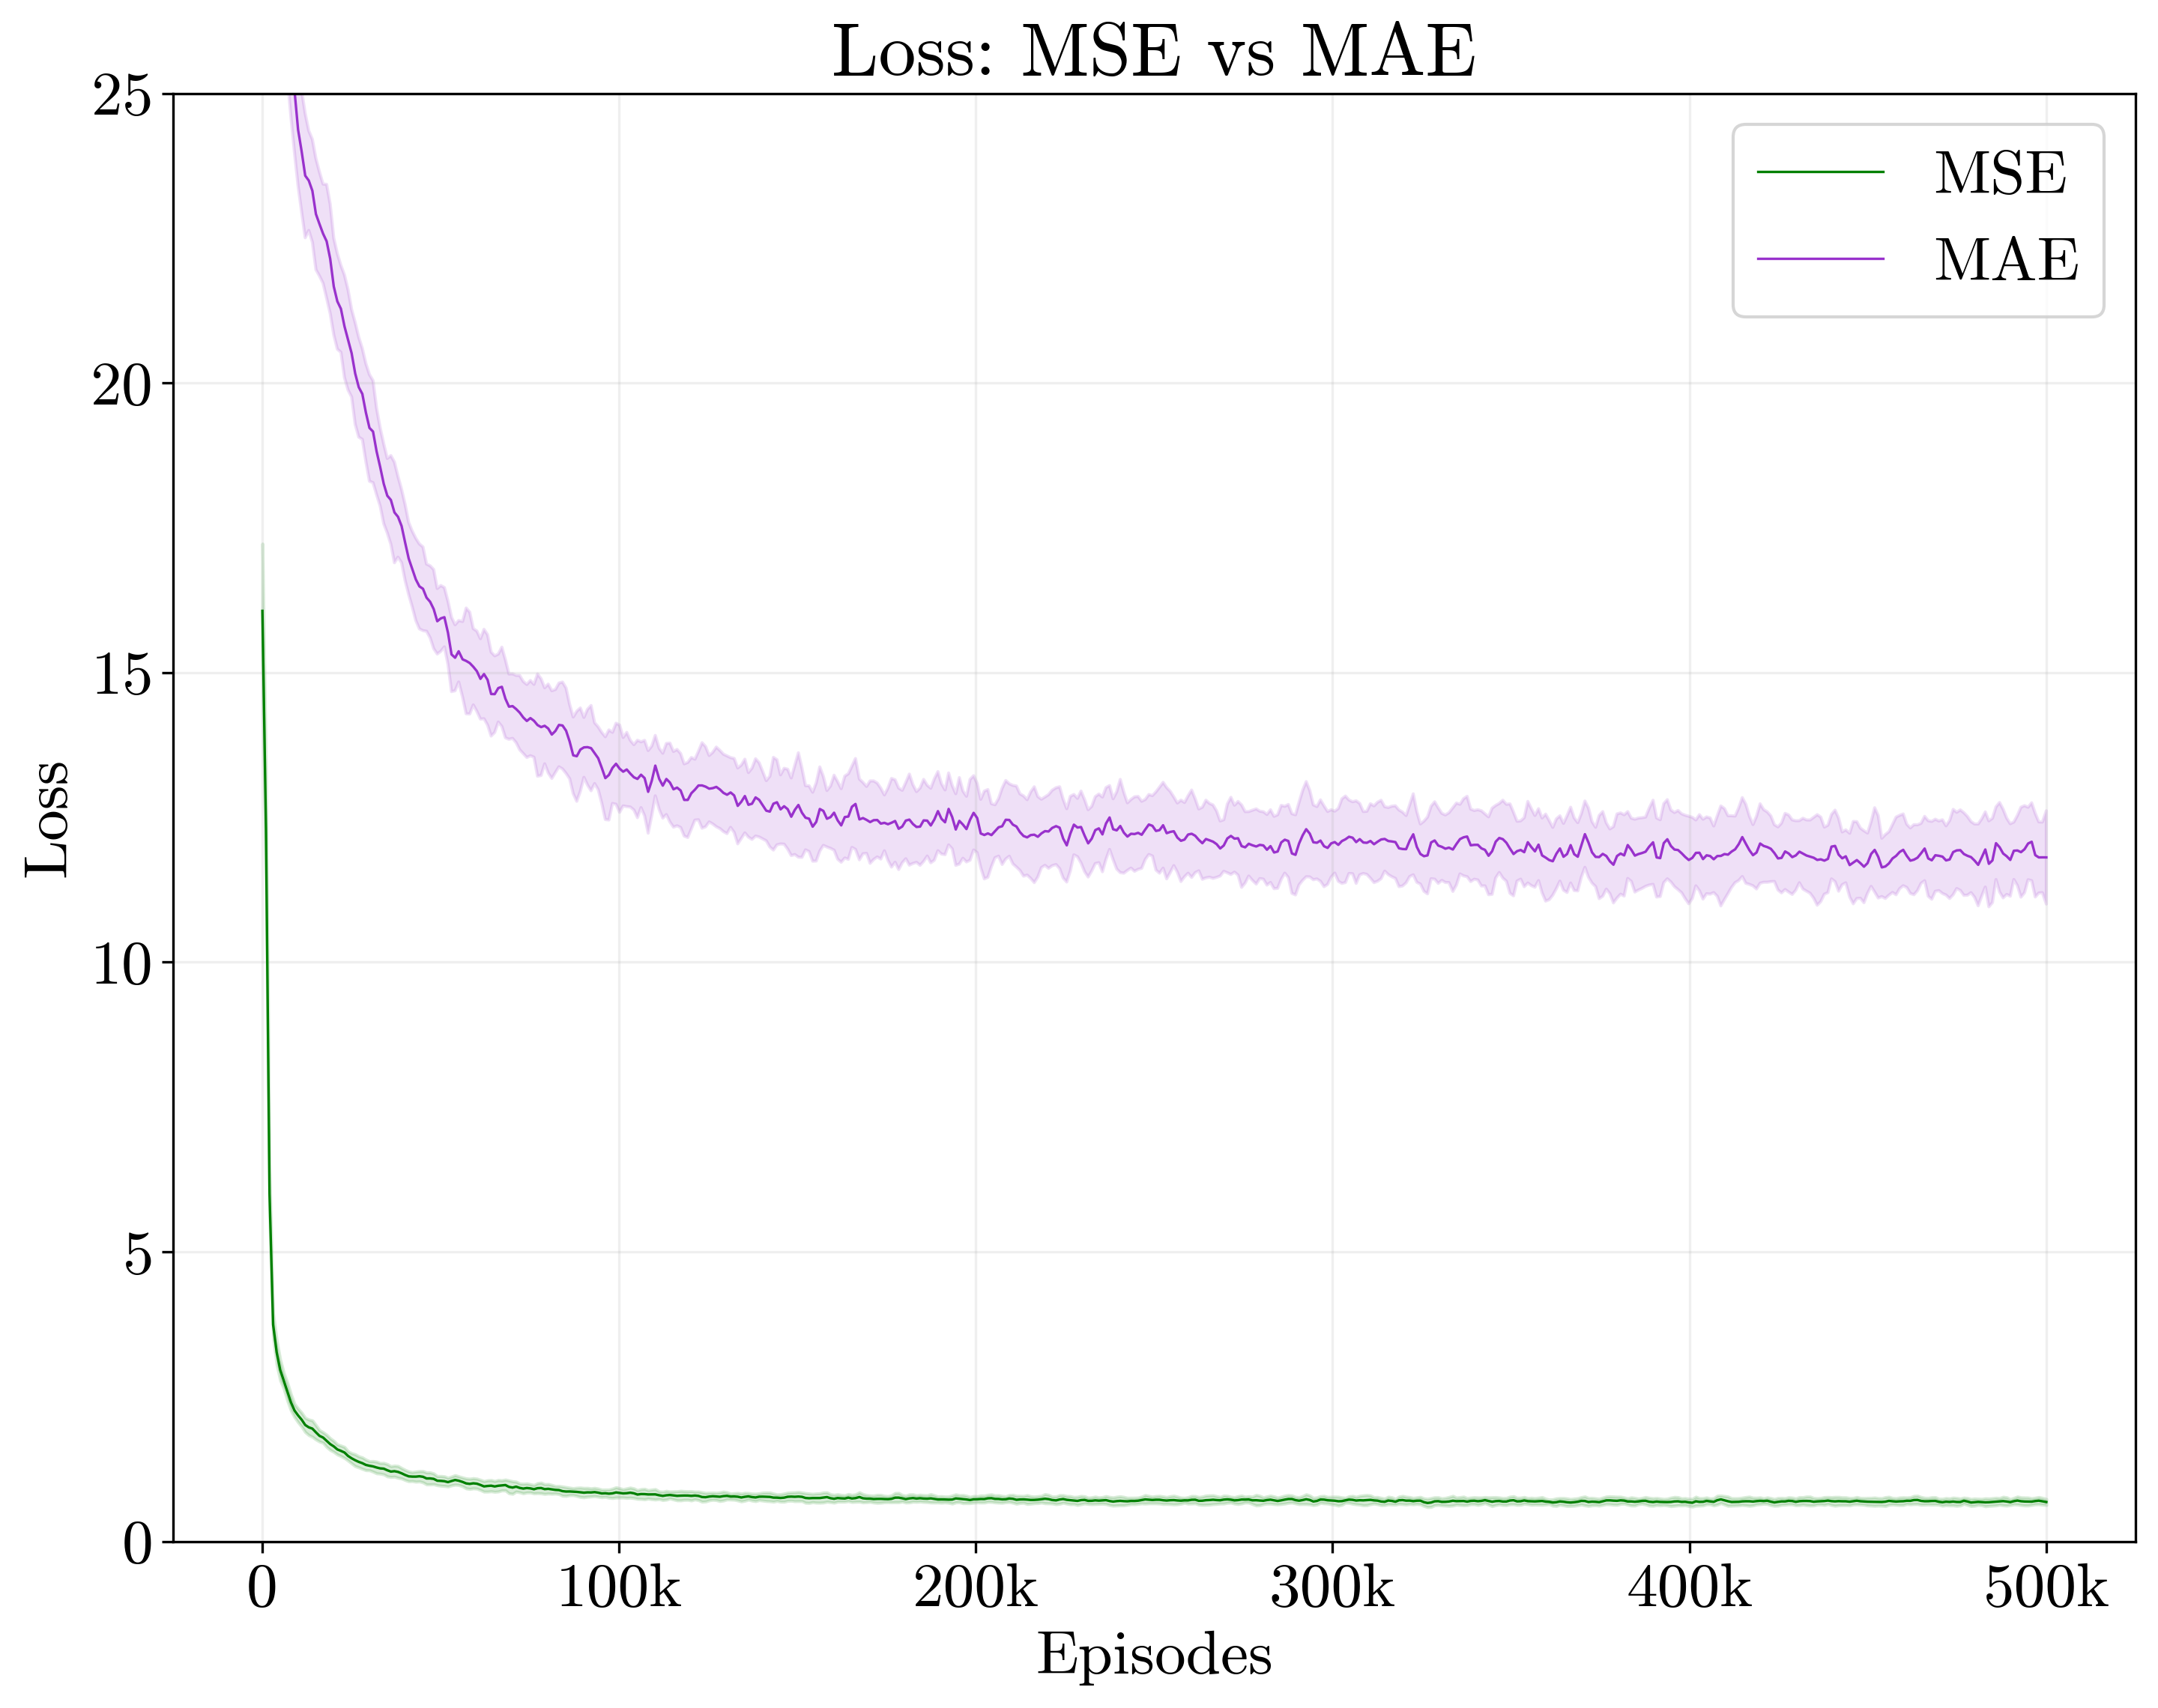

In [7]:
plt.figure()

plt.plot(episodes_mse, loss_mean_mse, label='MSE', color=colors[0], linewidth=lw)
plt.fill_between(episodes_mse, loss_mean_mse - loss_std_mse, loss_mean_mse + loss_std_mse, color=colors[0], alpha=alpha)

plt.plot(episodes_mae, loss_mean_mae, label='MAE', color=colors[1], linewidth=lw)
plt.fill_between(episodes_mae, loss_mean_mae - loss_std_mae, loss_mean_mae + loss_std_mae, color=colors[1], alpha=alpha)

plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.ylim(0, 25)
plt.title('Loss: MSE vs MAE')
plt.legend()
plt.grid(alpha=0.2)
apply_formatter()
plt.tight_layout()
plt.savefig('figures/loss_loss.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### Comparing agents: DQN vs double DQN

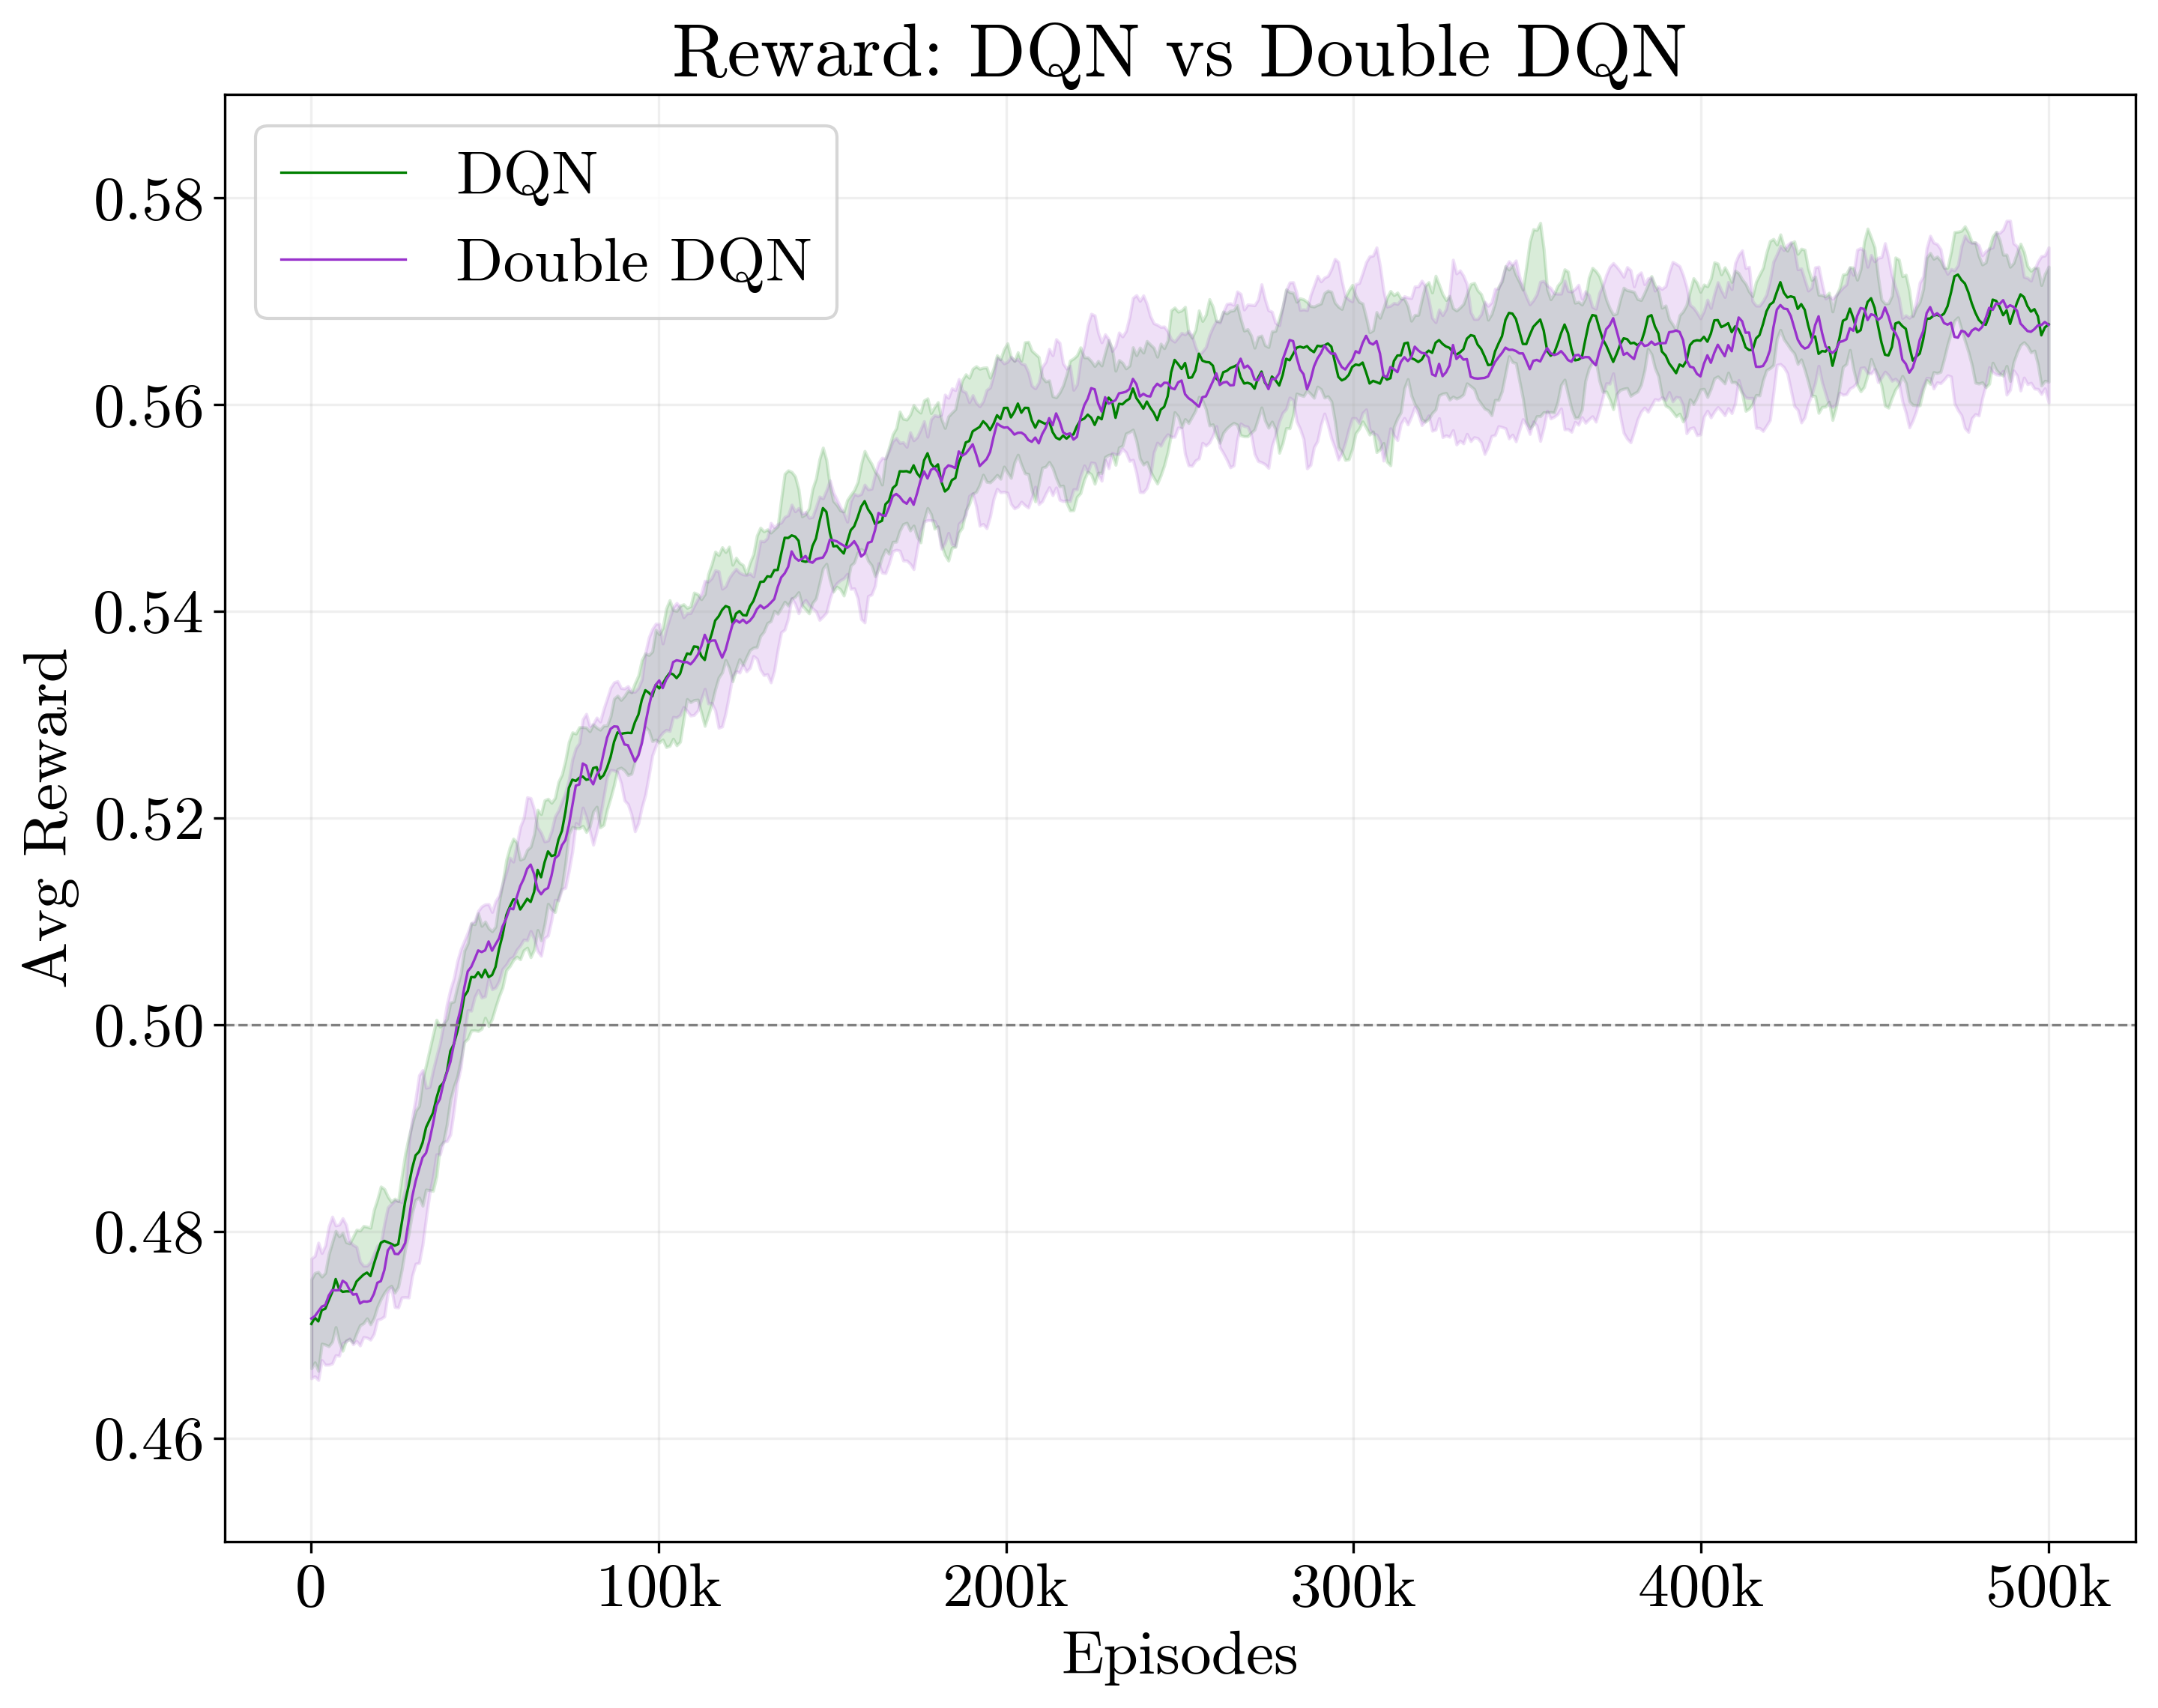

In [8]:
csv_path = "./csv_logs/fullinfo_agent_comparison"

csv_dqn_fullinfo = [os.path.join(csv_path, "log_dqn_0.csv"), os.path.join(csv_path, "log_dqn_1.csv"), os.path.join(csv_path, "log_dqn_2.csv")]
csv_ddqn_fullinfo = [os.path.join(csv_path, "log_double_dqn_0.csv"), os.path.join(csv_path, "log_double_dqn_1.csv"), os.path.join(csv_path, "log_double_dqn_2.csv")]

data_dqn_fullinfo = [pd.read_csv(f) for f in csv_dqn_fullinfo]
data_ddqn_fullinfo = [pd.read_csv(f) for f in csv_ddqn_fullinfo]

episodes_dqn_fullinfo, avg_reward_mean_dqn_fullinfo, avg_reward_std_dqn_fullinfo, loss_mean_dqn_fullinfo, loss_std_dqn_fullinfo = compute_mean_std(data_dqn_fullinfo)
episodes_ddqn_fullinfo, avg_reward_mean_ddqn_fullinfo, avg_reward_std_ddqn_fullinfo, loss_mean_ddqn_fullinfo, loss_std_ddqn_fullinfo = compute_mean_std(data_ddqn_fullinfo)

plt.figure()

plt.plot(episodes_dqn_fullinfo, avg_reward_mean_dqn_fullinfo, label='DQN', color=colors[0], linewidth=lw)
plt.fill_between(episodes_dqn_fullinfo, avg_reward_mean_dqn_fullinfo - avg_reward_std_dqn_fullinfo, avg_reward_mean_dqn_fullinfo + avg_reward_std_dqn_fullinfo, color=colors[0], alpha=alpha)

plt.plot(episodes_ddqn_fullinfo, avg_reward_mean_ddqn_fullinfo, label='Double DQN', color=colors[1], linewidth=lw)
plt.fill_between(episodes_ddqn_fullinfo, avg_reward_mean_ddqn_fullinfo - avg_reward_std_ddqn_fullinfo, avg_reward_mean_ddqn_fullinfo + avg_reward_std_ddqn_fullinfo, color=colors[1], alpha=alpha)

plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=lw)

plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.ylim(0.45, 0.59)
plt.title('Reward: DQN vs Double DQN')
plt.legend()
plt.grid(alpha=0.2)
apply_formatter()
plt.tight_layout()
plt.savefig('figures/dqn_ddqn_reward.pdf', dpi=300, bbox_inches='tight')
plt.show()

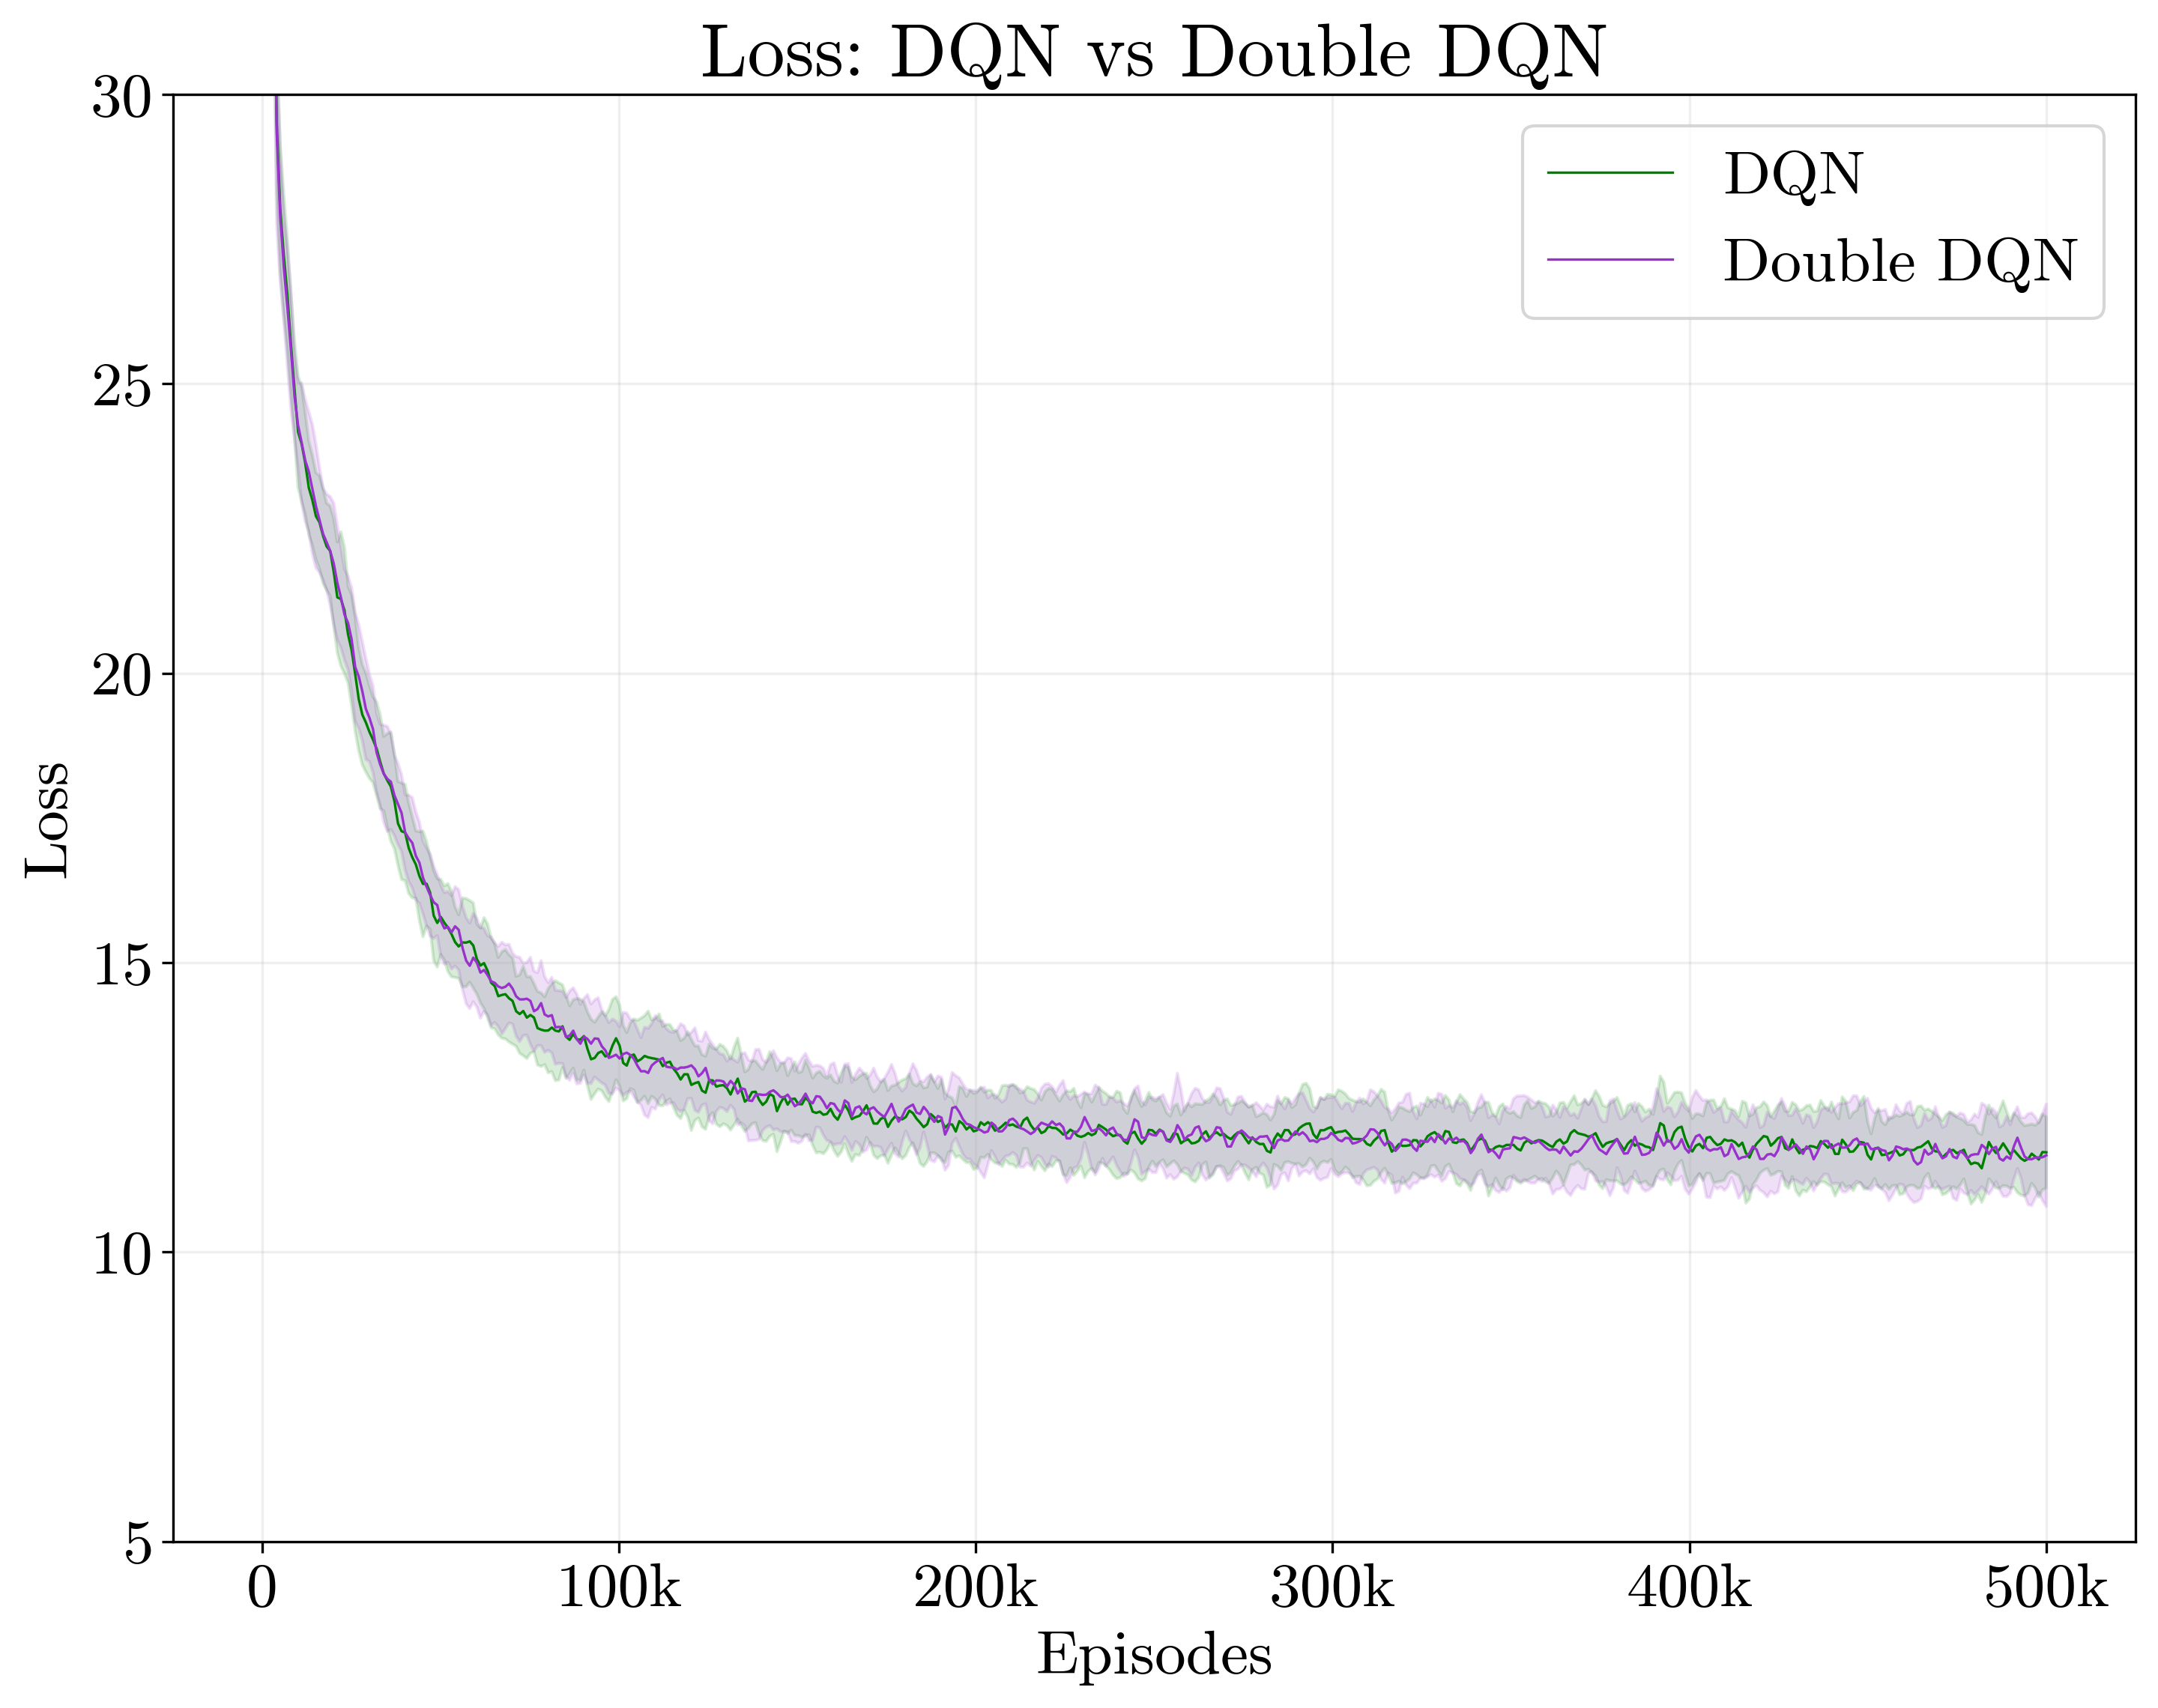

In [9]:
plt.figure()

plt.plot(episodes_dqn_fullinfo, loss_mean_dqn_fullinfo, label='DQN', color=colors[0], linewidth=lw)
plt.fill_between(episodes_dqn_fullinfo, loss_mean_dqn_fullinfo - loss_std_dqn_fullinfo, loss_mean_dqn_fullinfo + loss_std_dqn_fullinfo, color=colors[0], alpha=alpha)

plt.plot(episodes_ddqn_fullinfo, loss_mean_ddqn_fullinfo, label='Double DQN', color=colors[1], linewidth=lw)
plt.fill_between(episodes_ddqn_fullinfo, loss_mean_ddqn_fullinfo - loss_std_ddqn_fullinfo, loss_mean_ddqn_fullinfo + loss_std_ddqn_fullinfo, color=colors[1], alpha=alpha)

plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.ylim(5, 30)
plt.title('Loss: DQN vs Double DQN')
plt.legend()
plt.grid(alpha=0.2)
apply_formatter()
plt.tight_layout()
plt.savefig('figures/dqn_ddqn_loss.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### Full information vs partial information (both with DQN and double DQN)

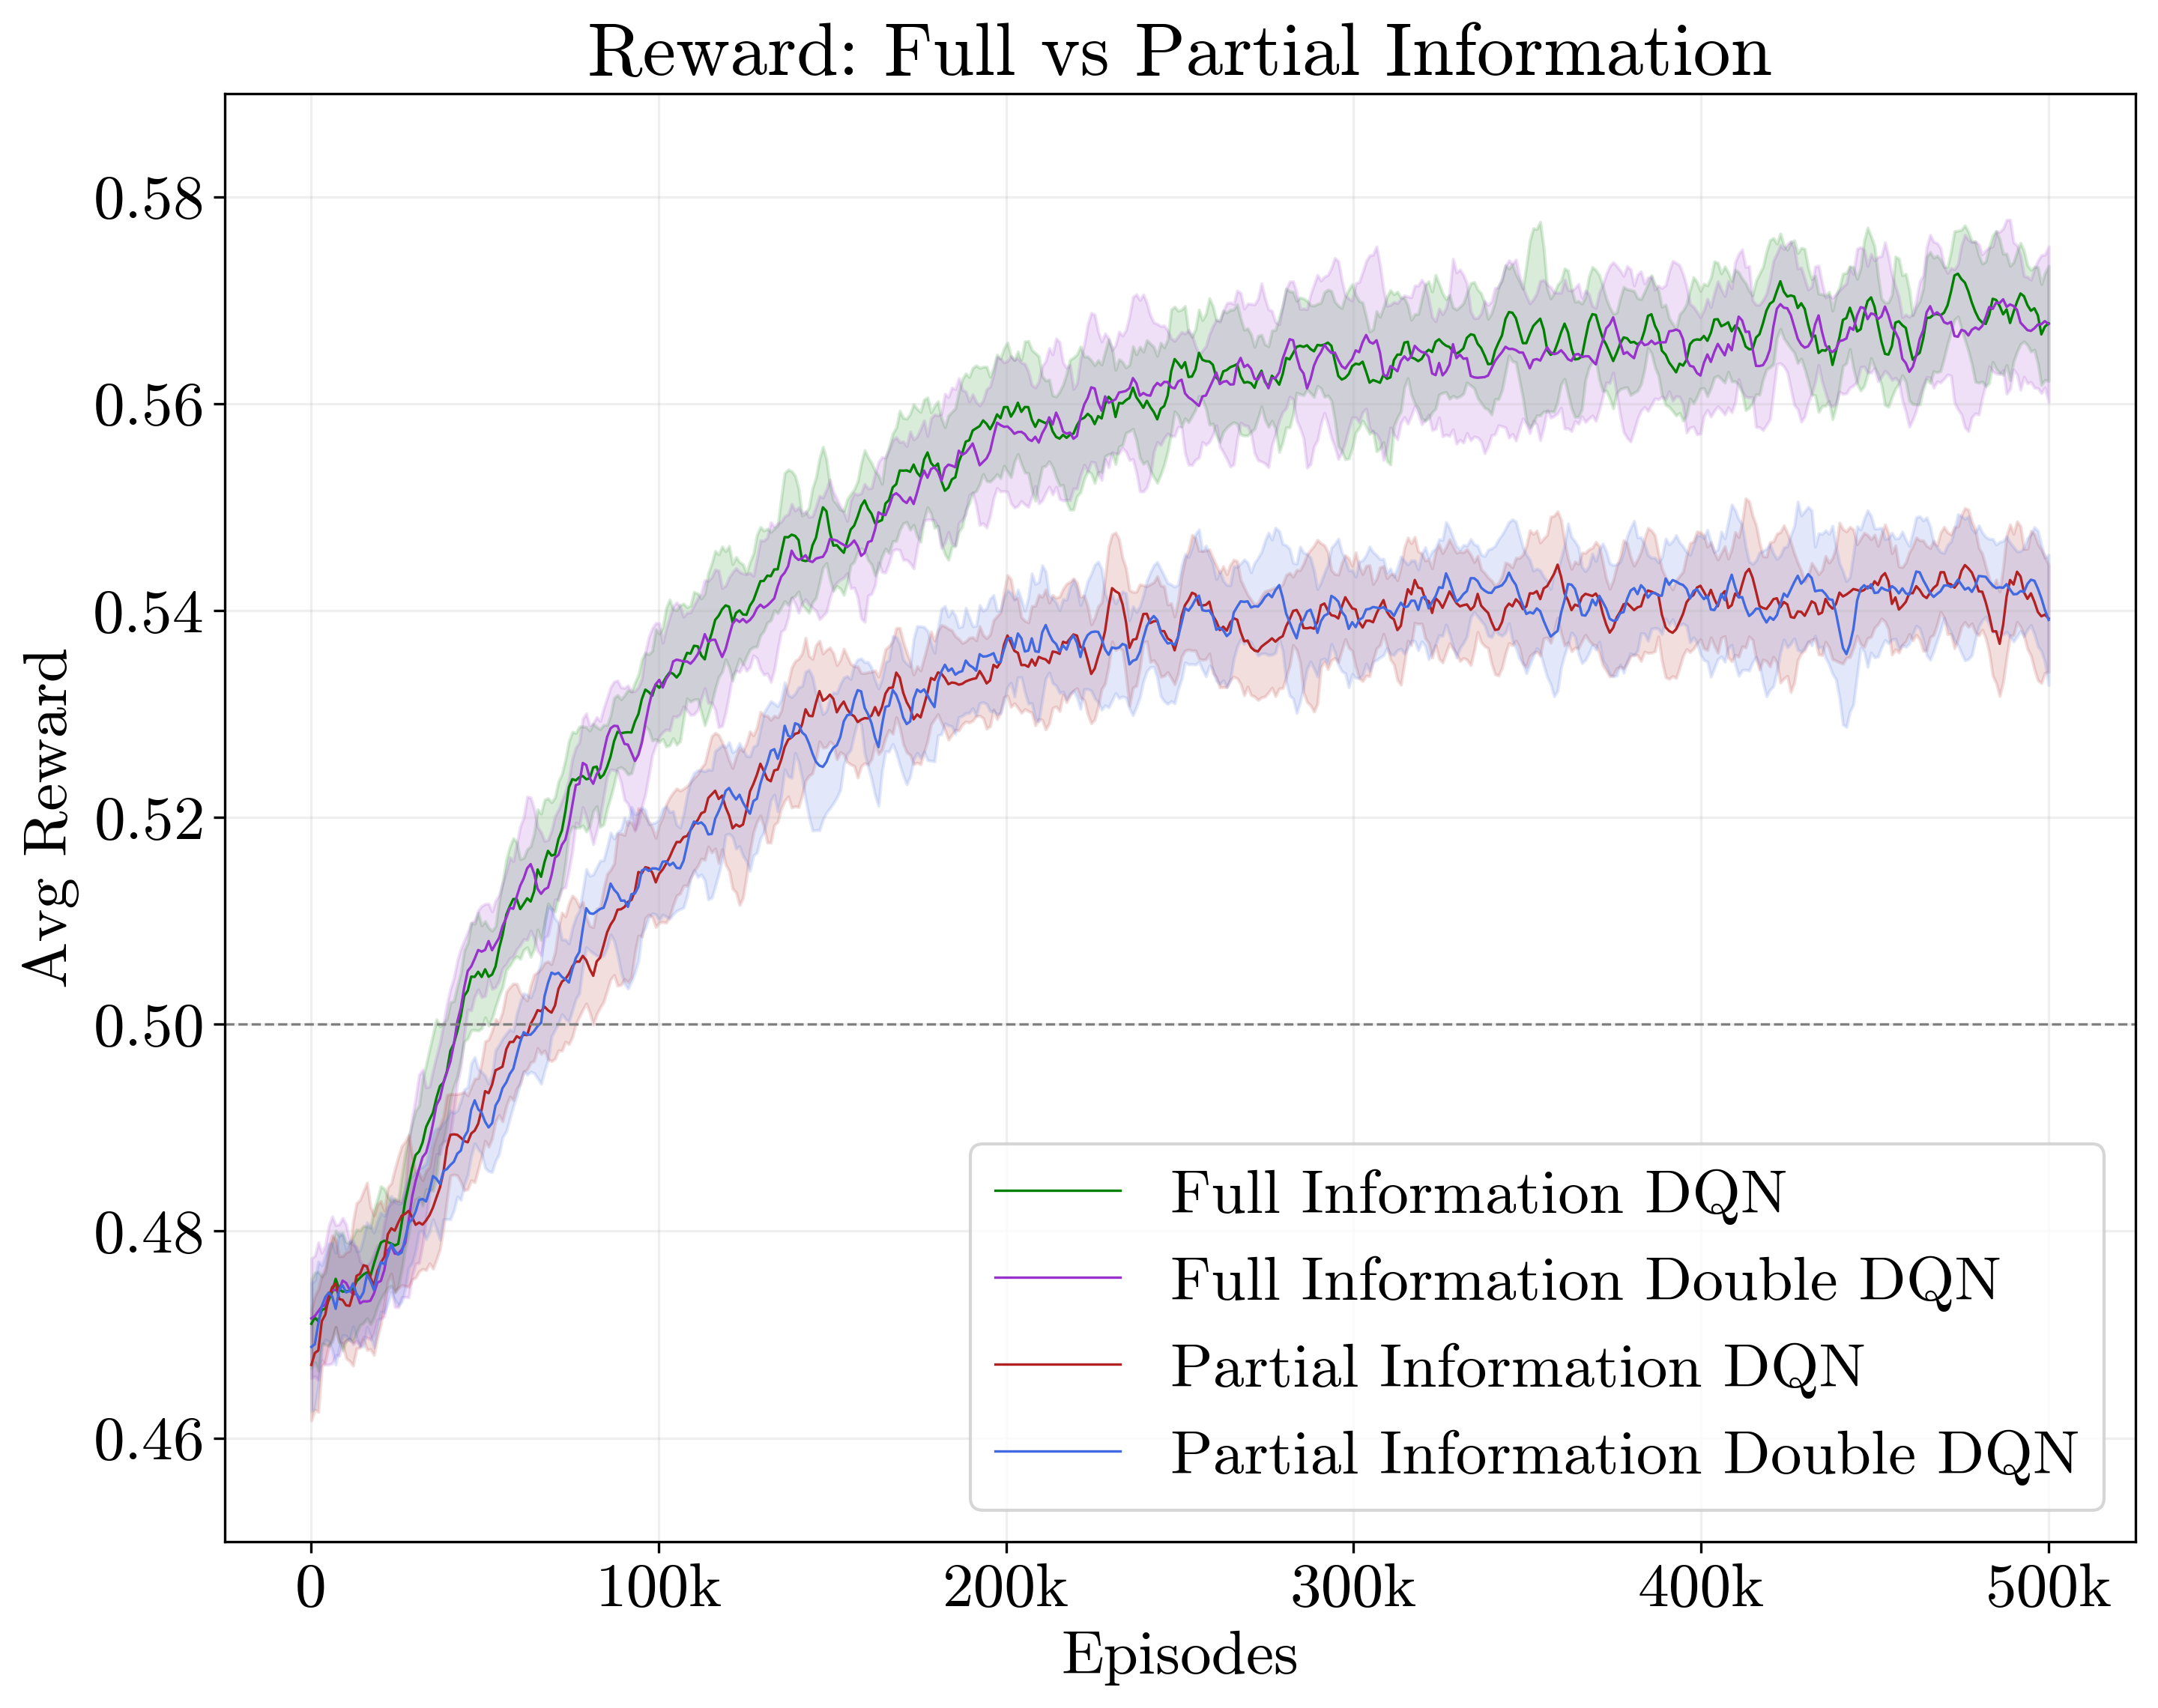

In [10]:
csv_path = "./csv_logs/partinfo_agent_comparison"

csv_dqn_partinfo = [os.path.join(csv_path, "log_dqn_0.csv"), os.path.join(csv_path, "log_dqn_1.csv"), os.path.join(csv_path, "log_dqn_2.csv")]
csv_ddqn_partinfo = [os.path.join(csv_path, "log_double_dqn_0.csv"), os.path.join(csv_path, "log_double_dqn_1.csv"), os.path.join(csv_path, "log_double_dqn_2.csv")]

data_dqn_partinfo = [pd.read_csv(f) for f in csv_dqn_partinfo]
data_ddqn_partinfo = [pd.read_csv(f) for f in csv_ddqn_partinfo]

episodes_dqn_partinfo, avg_reward_mean_dqn_partinfo, avg_reward_std_dqn_partinfo, loss_mean_dqn_partinfo, loss_std_dqn_partinfo = compute_mean_std(data_dqn_partinfo)
episodes_ddqn_partinfo, avg_reward_mean_ddqn_partinfo, avg_reward_std_ddqn_partinfo, loss_mean_ddqn_partinfo, loss_std_ddqn_partinfo = compute_mean_std(data_ddqn_partinfo)

plt.figure()

plt.plot(episodes_dqn_fullinfo, avg_reward_mean_dqn_fullinfo, label='Full Information DQN', color=colors[0], linewidth=lw)
plt.fill_between(episodes_dqn_fullinfo, avg_reward_mean_dqn_fullinfo - avg_reward_std_dqn_fullinfo, avg_reward_mean_dqn_fullinfo + avg_reward_std_dqn_fullinfo, color=colors[0], alpha=alpha)

plt.plot(episodes_ddqn_fullinfo, avg_reward_mean_ddqn_fullinfo, label='Full Information Double DQN', color=colors[1], linewidth=lw)
plt.fill_between(episodes_ddqn_fullinfo, avg_reward_mean_ddqn_fullinfo - avg_reward_std_ddqn_fullinfo, avg_reward_mean_ddqn_fullinfo + avg_reward_std_ddqn_fullinfo, color=colors[1], alpha=alpha)

plt.plot(episodes_dqn_partinfo, avg_reward_mean_dqn_partinfo, label='Partial Information DQN', color=colors[2], linewidth=lw)
plt.fill_between(episodes_dqn_partinfo, avg_reward_mean_dqn_partinfo - avg_reward_std_dqn_partinfo, avg_reward_mean_dqn_partinfo + avg_reward_std_dqn_partinfo, color=colors[2], alpha=alpha)

plt.plot(episodes_ddqn_partinfo, avg_reward_mean_ddqn_partinfo, label='Partial Information Double DQN', color=colors[3], linewidth=lw)
plt.fill_between(episodes_ddqn_partinfo, avg_reward_mean_ddqn_partinfo - avg_reward_std_ddqn_partinfo, avg_reward_mean_ddqn_partinfo + avg_reward_std_ddqn_partinfo, color=colors[3], alpha=alpha)

plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=lw)

plt.xlabel('Episodes')
plt.ylabel('Avg Reward')
plt.ylim(0.45, 0.59)
plt.title('Reward: Full vs Partial Information')
plt.legend()
plt.grid(alpha=0.2)
apply_formatter()
plt.tight_layout()
plt.savefig('figures/fullinfo_partinfo_reward.pdf', dpi=300, bbox_inches='tight')
plt.show()

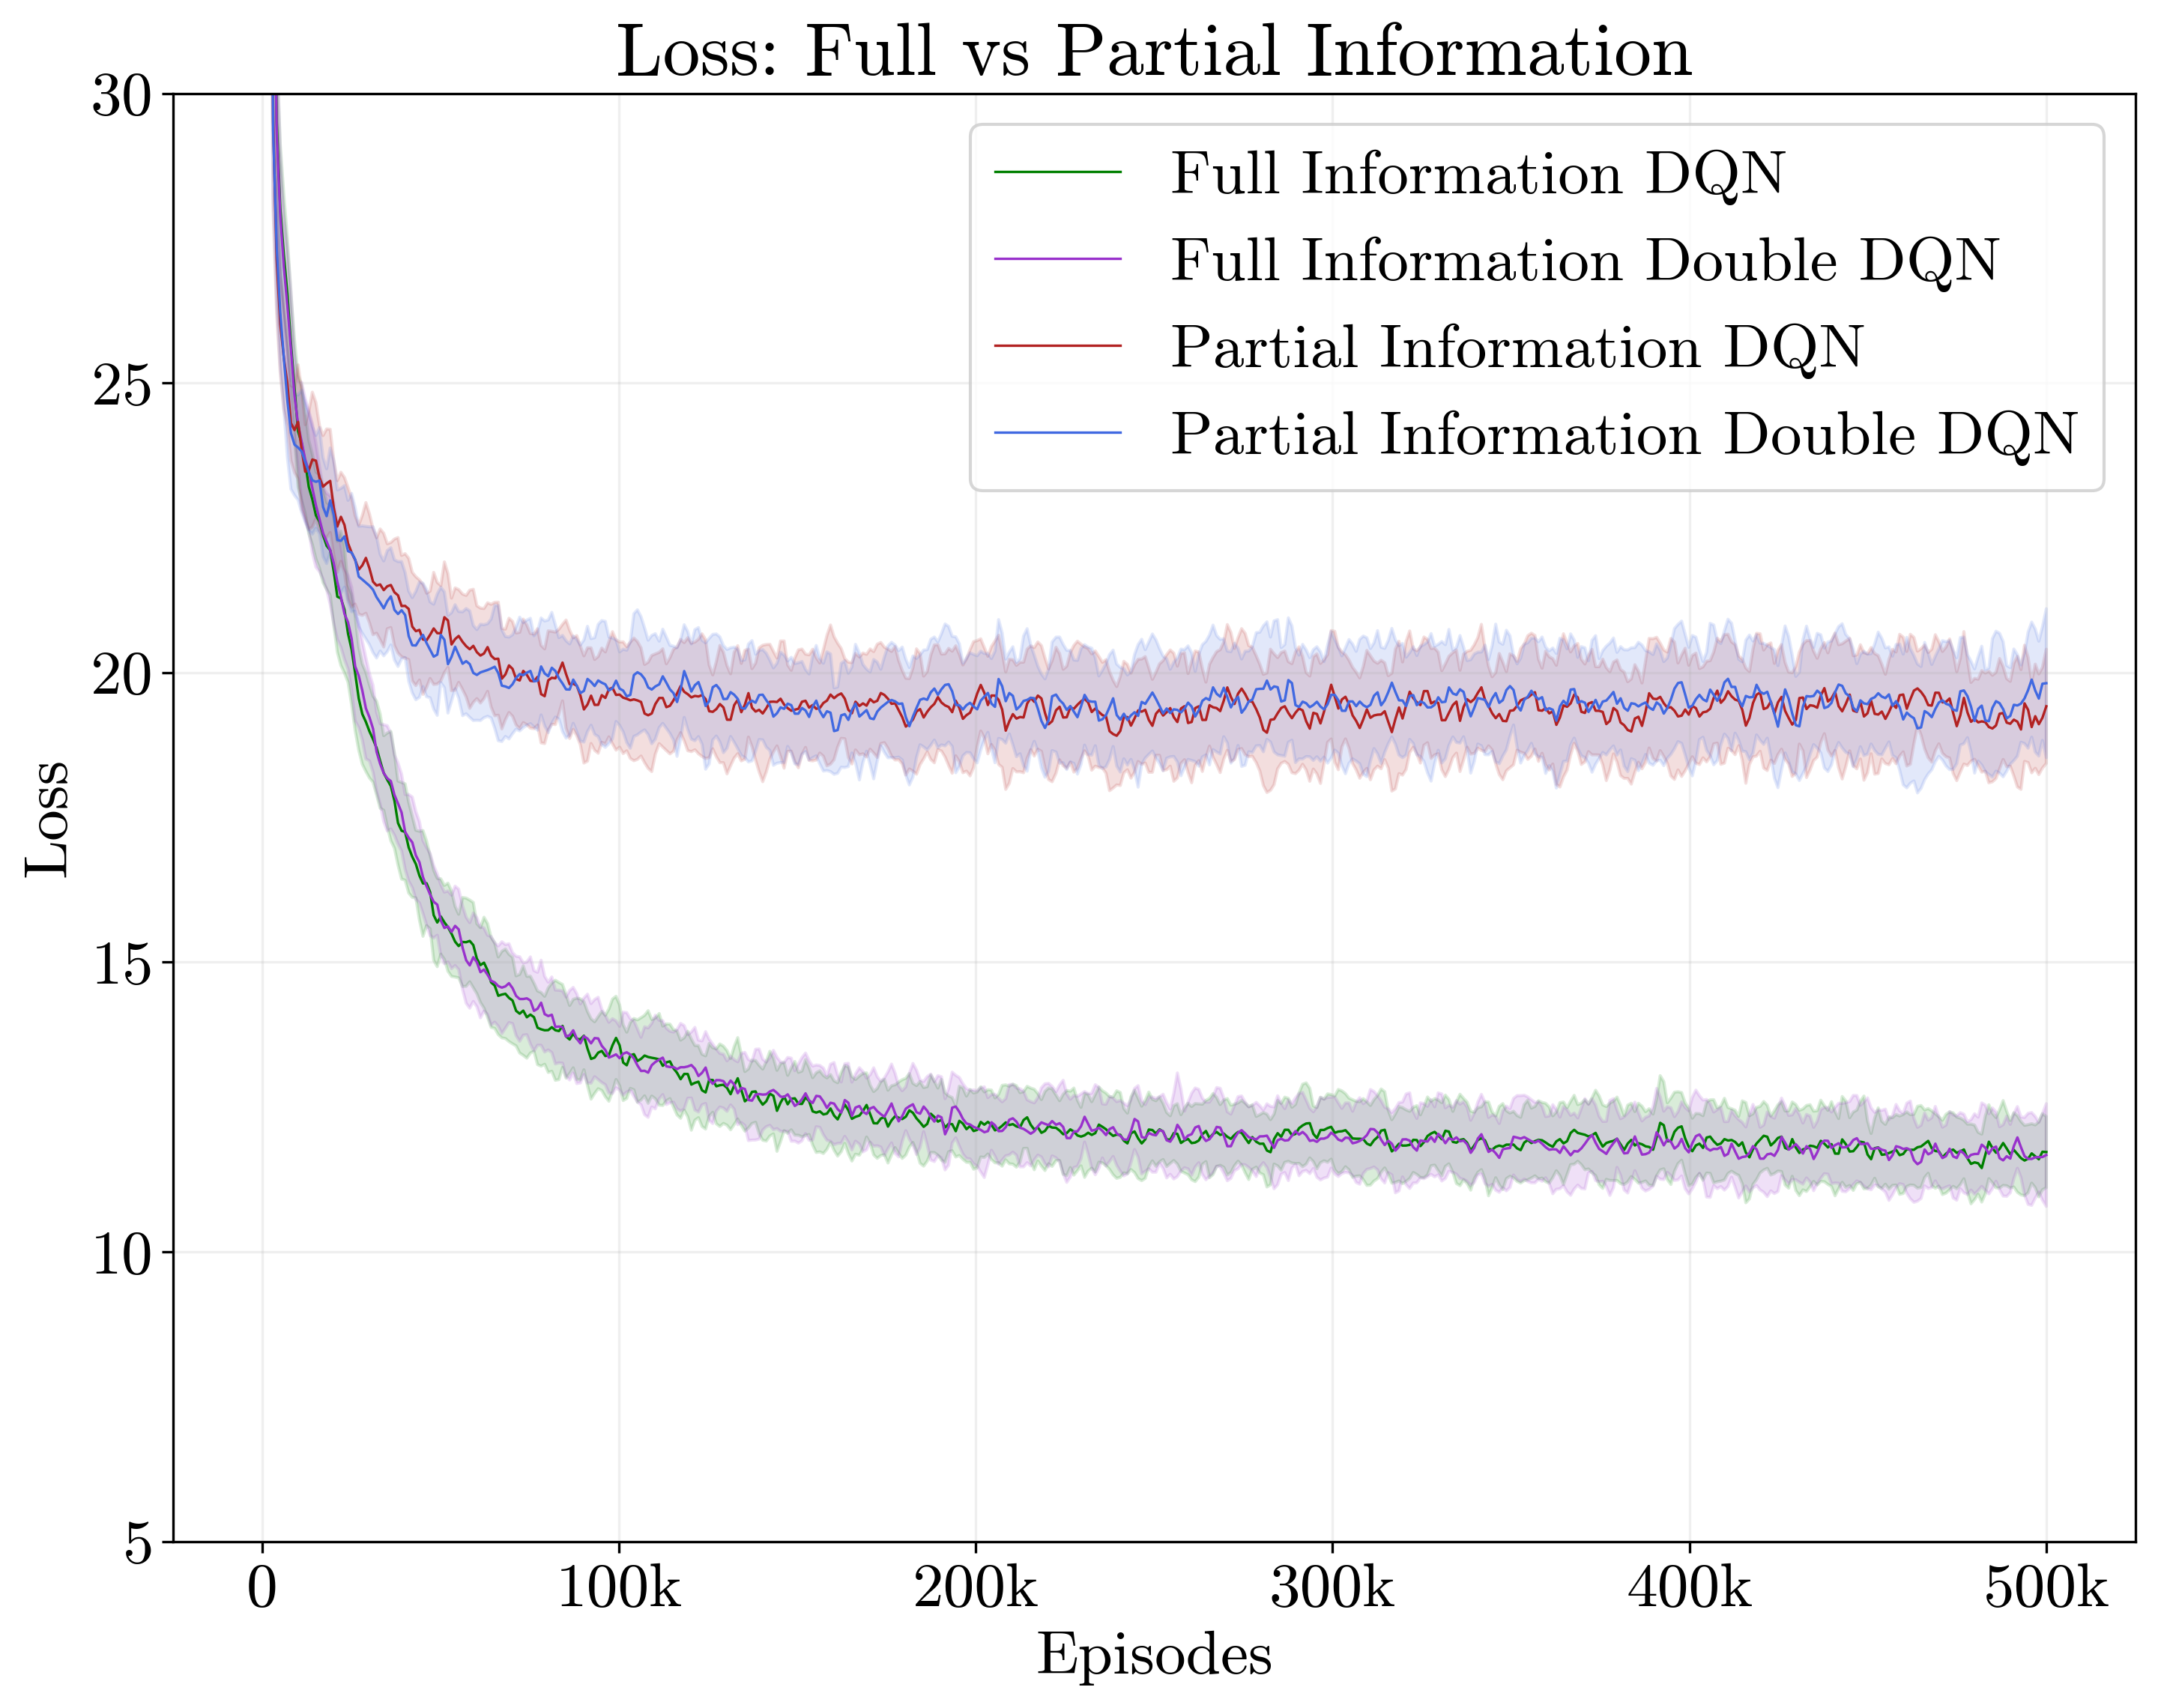

In [11]:
plt.figure()

plt.plot(episodes_dqn_fullinfo, loss_mean_dqn_fullinfo, label='Full Information DQN', color=colors[0], linewidth=lw)
plt.fill_between(episodes_dqn_fullinfo, loss_mean_dqn_fullinfo - loss_std_dqn_fullinfo, loss_mean_dqn_fullinfo + loss_std_dqn_fullinfo, color=colors[0], alpha=alpha)

plt.plot(episodes_ddqn_fullinfo, loss_mean_ddqn_fullinfo, label='Full Information Double DQN', color=colors[1], linewidth=lw)
plt.fill_between(episodes_ddqn_fullinfo, loss_mean_ddqn_fullinfo - loss_std_ddqn_fullinfo, loss_mean_ddqn_fullinfo + loss_std_ddqn_fullinfo, color=colors[1], alpha=alpha)

plt.plot(episodes_dqn_partinfo, loss_mean_dqn_partinfo, label='Partial Information DQN', color=colors[2], linewidth=lw)
plt.fill_between(episodes_dqn_partinfo, loss_mean_dqn_partinfo - loss_std_dqn_partinfo, loss_mean_dqn_partinfo + loss_std_dqn_partinfo, color=colors[2], alpha=alpha)

plt.plot(episodes_ddqn_partinfo, loss_mean_ddqn_partinfo, label='Partial Information Double DQN', color=colors[3], linewidth=lw)
plt.fill_between(episodes_ddqn_partinfo, loss_mean_ddqn_partinfo - loss_std_ddqn_partinfo, loss_mean_ddqn_partinfo + loss_std_ddqn_partinfo, color=colors[3], alpha=alpha)

plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.ylim(5, 30)
plt.title('Loss: Full vs Partial Information')
plt.legend()
plt.grid(alpha=0.2)
apply_formatter()
plt.tight_layout()
plt.savefig('figures/fullinfo_partinfo_loss.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Winrates

Chosen models (inside models directory):

Fullinfo:
- run_double_dqn_500000_128-128_relu_512_1_0.005_0.00005_50000_smooth_l1_2.pt &rarr; renamed to: FI_ddqn_128-128-500000.pt
- run_dqn_500000_128-128_relu_512_1_0.005_0.00005_50000_smooth_l1_1.pt &rarr; renamed to: FI_dqn_128-128-500000.pt

Partinfo:
- run_double_dqn_500000_128-128_relu_512_1_0.005_0.00005_50000_smooth_l1_0.pt &rarr; renamed to: PI_ddqn_128-128-500000.pt
- run_dqn_500000_128-128_relu_512_1_0.005_0.00005_50000_smooth_l1_2.pt &rarr; renamed to: PI_dqn_128-128-500000.pt

In [12]:
import sys
import os

src_path = os.path.abspath("src")
if src_path not in sys.path:
    sys.path.append(src_path)
    
import copy
import random
import torch
import numpy as np
from tqdm import tqdm

from agents.random_agent import Random_Agent
from agents.greedy_agent import Greedy_Agent
from agents.dqn_agent import DQN_Agent
from agents.double_dqn_agent import Double_DQN_Agent
from envs.jassenv import JassEnv
import utils


PRINT_ENV = False

def evaluate_agents(agent0, agent1, seeds):  
    
    N_EPISODES = 1000
    
    agents = [agent0, agent1]
    winning_rate_agent0 = []
    winning_rate_agent1 = []
    
    for i in tqdm(range(len(seeds))):
        
        utils.seed_everything(seeds[i])
        
        # Alternating agent's team for fairness
        p0 = copy.deepcopy(agents[i % 2])
        p0.player_id = 0
        p0.team_id = 0
        
        p1 = copy.deepcopy(agents[1 - (i % 2)])
        p1.player_id = 1
        p1.team_id = 1
        players = [p0,
                   p1,
                   Greedy_Agent(player_id=2, team_id=0),
                   Greedy_Agent(player_id=3, team_id=1)]
        
        # Initialize the environment
        env = JassEnv(players=players, print_globals=PRINT_ENV)
        starting_player_id = 0
        rewards_list_per_player = []
        rewards_list_per_team = []
        won_games_per_player = [0, 0, 0, 0]
        won_games_per_team = [0, 0] # Team 0, Team 1
    
        for _ in range(1, N_EPISODES+1):
            
            state = env.reset(starting_player_id=starting_player_id)
            
            is_geschoben = False
            game_type = players[starting_player_id].choose_game_type(state=state)
            if game_type ==  "SCHIEBEN":
                is_geschoben = True
                team_mate_id = (starting_player_id + 2) % 4
                game_type = players[team_mate_id].choose_game_type(state=state, is_geschoben=True)
            
            env.set_game_type(game_type, is_geschoben)
            
            current_turn = env.get_current_turn()
            done = False
            
            while not done:
                action = players[current_turn].act(state)
                new_state, rewards, done = env.step(action)
                current_turn = env.get_current_turn()
                state = copy.deepcopy(new_state)
            
            starting_player_id = (starting_player_id + 1) % 4
            
            rewards_list_per_player.append(env.rewards_per_player)
            rewards_list_per_team.append(env.rewards_per_team)
            
            winner_player = np.argmax(env.rewards_per_player)
            won_games_per_player[winner_player] += 1
            
            winner_team = np.argmax(env.rewards_per_team)
            won_games_per_team[winner_team] += 1
        
        winning_rate_agent0.append(won_games_per_team[i % 2] / N_EPISODES)
        winning_rate_agent1.append(won_games_per_team[1 - (i % 2)] / N_EPISODES)
        
    return winning_rate_agent0, winning_rate_agent1

def get_mean_std(winning_rate_team0, winnin_rate_team1):
    return np.mean(winning_rate_team0), np.std(winning_rate_team0), np.mean(winnin_rate_team1), np.std(winnin_rate_team1)

In [13]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the agents and load models
agent_random = Random_Agent(player_id=0, team_id=0)
agent_greedy = Greedy_Agent(player_id=0, team_id=0)

agent_fi_ddqn = Double_DQN_Agent(player_id=0,
                                team_id=0,
                                deterministic=True,
                                hide_opponents_hands=False,
                                hidden_sizes=[128, 128],
                                activation="relu",
                                device=device)

agent_fi_dqn = DQN_Agent(player_id=0,
                         team_id=0,
                         deterministic=True,
                         hide_opponents_hands=False,
                         hidden_sizes=[128, 128],
                         activation="relu",
                         device=device)

agent_pi_ddqn = Double_DQN_Agent(player_id=0,
                                 team_id=0,
                                 deterministic=True,
                                 hide_opponents_hands=True,
                                 hidden_sizes=[128, 128],
                                 activation="relu",
                                 device=device)

agent_pi_dqn = DQN_Agent(player_id=0,
                         team_id=0,
                         deterministic=True,
                         hide_opponents_hands=True,
                         hidden_sizes=[128, 128],
                         activation="relu",
                         device=device)

agent_fi_ddqn.load_model("models/FI_ddqn_128-128_500000.pt")
agent_fi_dqn.load_model("models/FI_dqn_128-128_500000.pt")
agent_pi_ddqn.load_model("models/PI_ddqn_128-128_500000.pt")
agent_pi_dqn.load_model("models/PI_dqn_128-128_500000.pt")

seeds = [3, 4, 5, 6]

In [14]:
# Random agent vs Greedy agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_random, agent_greedy, seeds))
print(f"Random: {mean_0:.2f} ± {std_0:.2f} \nGreedy: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:31<00:00,  7.97s/it]

Random: 0.44 ± 0.01 
Greedy: 0.56 ± 0.01


In [15]:
# Random agent vs DQN-FI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_random, agent_fi_dqn, seeds))
print(f"Random: {mean_0:.2f} ± {std_0:.2f} \nDQN-FI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:34<00:00,  8.65s/it]

Random: 0.33 ± 0.01 
DQN-FI: 0.67 ± 0.01


In [16]:
# Random agent vs DQN-PI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_random, agent_pi_dqn, seeds))
print(f"Random: {mean_0:.2f} ± {std_0:.2f} \nDQN-PI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:34<00:00,  8.67s/it]

Random: 0.37 ± 0.01 
DQN-PI: 0.63 ± 0.01


In [17]:
# Random agent vs DDQN-FI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_random, agent_fi_ddqn, seeds))
print(f"Random: {mean_0:.2f} ± {std_0:.2f} \nDDQN-FI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:34<00:00,  8.67s/it]

Random: 0.33 ± 0.01 
DDQN-FI: 0.67 ± 0.01


In [18]:
# Random agent vs DDQN-PI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_random, agent_pi_ddqn, seeds))
print(f"Random: {mean_0:.2f} ± {std_0:.2f} \nDDQN-PI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:34<00:00,  8.69s/it]

Random: 0.37 ± 0.01 
DDQN-PI: 0.63 ± 0.01


In [19]:
# Greedy agent vs DQN-FI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_greedy, agent_fi_dqn, seeds))
print(f"Greedy: {mean_0:.2f} ± {std_0:.2f} \nDQN-FI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:34<00:00,  8.70s/it]

Greedy: 0.38 ± 0.02 
DQN-FI: 0.62 ± 0.02


In [20]:
# Greedy agent vs DQN-PI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_greedy, agent_pi_dqn, seeds))
print(f"Greedy: {mean_0:.2f} ± {std_0:.2f} \nDQN-PI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:35<00:00,  8.77s/it]

Greedy: 0.43 ± 0.03 
DQN-PI: 0.57 ± 0.03


In [21]:
# Greedy agent vs DDQN-FI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_greedy, agent_fi_ddqn, seeds))
print(f"Greedy: {mean_0:.2f} ± {std_0:.2f} \nDDQN-FI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:35<00:00,  8.83s/it]

Greedy: 0.38 ± 0.02 
DDQN-FI: 0.62 ± 0.02


In [22]:
# Greedy agent vs DDQN-PI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_greedy, agent_pi_ddqn, seeds))
print(f"Greedy: {mean_0:.2f} ± {std_0:.2f} \nDDQN-PI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:35<00:00,  8.76s/it]

Greedy: 0.43 ± 0.02 
DDQN-PI: 0.57 ± 0.02


In [23]:
# DQN-FI agent vs DQN-PI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_fi_dqn, agent_pi_dqn, seeds))
print(f"DQN-FI: {mean_0:.2f} ± {std_0:.2f} \nDQN-PI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:37<00:00,  9.37s/it]

DQN-FI: 0.55 ± 0.01 
DQN-PI: 0.45 ± 0.01


In [24]:
# DQN-FI agent vs DDQN-FI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_fi_dqn, agent_fi_ddqn, seeds))
print(f"DQN-FI: {mean_0:.2f} ± {std_0:.2f} \nDDQN-FI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:37<00:00,  9.38s/it]

DQN-FI: 0.51 ± 0.03 
DDQN-FI: 0.49 ± 0.03


In [25]:
# DQN-FI agent vs DDQN-PI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_fi_dqn, agent_pi_ddqn, seeds))
print(f"DQN-FI: {mean_0:.2f} ± {std_0:.2f} \nDDQN-PI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:37<00:00,  9.39s/it]

DQN-FI: 0.55 ± 0.02 
DDQN-PI: 0.45 ± 0.02


In [26]:
# DQN-PI agent vs DDQN-FI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_pi_dqn, agent_fi_ddqn, seeds))
print(f"DQN-PI: {mean_0:.2f} ± {std_0:.2f} \nDDQN-FI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:37<00:00,  9.37s/it]

DQN-PI: 0.44 ± 0.03 
DDQN-FI: 0.56 ± 0.03


In [27]:
# DQN-PI agent vs DDQN-PI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_pi_dqn, agent_pi_ddqn, seeds))
print(f"DQN-PI: {mean_0:.2f} ± {std_0:.2f} \nDDQN-PI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:37<00:00,  9.38s/it]

DQN-PI: 0.50 ± 0.03 
DDQN-PI: 0.50 ± 0.03


In [28]:
# DDQN-FI agent vs DDQN-PI agent
mean_0, std_0, mean_1, std_1 = get_mean_std(*evaluate_agents(agent_fi_ddqn, agent_pi_ddqn, seeds))
print(f"DDQN-FI: {mean_0:.2f} ± {std_0:.2f} \nDDQN-PI: {mean_1:.2f} ± {std_1:.2f}")

100%|██████████| 4/4 [00:37<00:00,  9.38s/it]

DDQN-FI: 0.56 ± 0.03 
DDQN-PI: 0.44 ± 0.03
